In [1]:
import scipy
import matplotlib
import numpy as np
import math
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import colorbar
from matplotlib.patches import Ellipse
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import LogFormatterExponent
from matplotlib.ticker import LogLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from astropy.table import Table, vstack, join
from astropy.io import ascii, fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from collections import Counter
from matplotlib.lines import Line2D
import lmfit
from sklearn.linear_model import LinearRegression
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy import interpolate
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
pd.options.mode.copy_on_write = True
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.optimize import fsolve
import tensorflow as tf

2025-02-27 13:39:55.066225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740681595.109729 1734484 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740681595.122029 1734484 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 13:39:55.167386: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Common function for reading files and preprocessing data
#def read_fits_and_cut(input_file_name):
#    table = Table.read(input_file_name)
#    df = table.to_pandas()
#    df['id'] = df['id'].astype(str)
#    for column in df.columns:
#        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
#            df[column] = df[column].str.decode('utf-8')
#    df['g0'] = df['gpsf'] - df['a_g'] #a_g: galactic extinction in g band (HSC has girn-band)
#    df['i0'] = df['ipsf'] - df['a_i']
#    df['n0'] = df['npsf'] - df['a_n']
#    df['MGH'] = df['MGFE'] + df['FEH']
#    #df = df[(-0.0 < df['MGFEERR']) & (df['MGFEERR'] < 0.5)] #or df = df[(-0.80 <= df['MGFE']) & (df['MGFE'] < 1.20)]
#    return df

def read_fits_and_cut_plus(input_file_name):
    df = pd.read_csv(input_file_name)
    df['id'] = df['id'].astype(str)
    df.drop(['MASK','SLIT','B', 'V', 'R', 'I', 'J', 'H', 'K', 'BERR', 'VERR', 'RERR', 'IERR', 'JERR', 'HERR', 'KERR', 'PHOT_COLOR',
            'AGE','TEFFERR','LOGGERR','ALPHAFE', 'ALPHAFEERR','SIFE', 'SIFEERR', 'CAFE', 'CAFEERR', 'TIFE', 'TIFEERR'], axis=1, inplace=True)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df = df[(-0.0 < df['MGFEERR']) & (df['MGFEERR'] < 0.5)]
    return df
    
def read_hsc(input_file_name):
    data = ascii.read(input_file_name,
        names=['id', 'ra', 'dec', 'X', 'Y', 'ipsf', 'gpsf', 'npsf', 'ipsferr',
        'gpsferr', 'npsferr', 'cli', 'clg', 'cln', 'a_i', 'a_g', 'a_n'])
    df = data.to_pandas()
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    df['g0'] = df['gpsf'] - df['a_g']
    df['i0'] = df['ipsf'] - df['a_i']
    df['n0'] = df['npsf'] - df['a_n']
    return df

def read_hsc_members(input_file_name):
    df = pd.read_csv(input_file_name)
    df['id'] = df['id'].astype(str)
    for column in df.columns:
        if df[column].dtype == 'object' and isinstance(df[column][0], bytes):
            df[column] = df[column].str.decode('utf-8')
    return df

In [3]:
## Read HSC-DEIMOS files
fnx = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Fornax_HSC_DEIMOS_plus_w_age.csv')
scl = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Sculptor_HSC_DEIMOS_plus_w_age.csv')
umi = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Ursaminor_HSC_DEIMOS_plus_w_age.csv')
dra = read_fits_and_cut_plus('/emc1/home/jhong5/subaru_hsc/Draco_HSC_DEIMOS_plus_w_age.csv')
print(f'len(fnx) = {len(fnx)}') #485 -> 308
print(f'len(scl) = {len(scl)}') #405 -> 283
print(f'len(umi) = {len(umi)}') #263 -> 93
print(f'len(dra) = {len(dra)}') #168 -> 93

## Read whole HSC data
hsc_fnx = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/fornax_tpall3e_g24_radec_members_cut.csv')
hsc_scl = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/sculptor_tpall3e_g24_radec_members_cut.csv')
hsc_umi = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/ursaminor_tpall3e_g24_radec_members_cut.csv')
hsc_dra = read_hsc_members('/emc1/home/jhong5/subaru_hsc/hsc_data/draco_tpall3e_g24_radec_members_cut.csv')
print(f'len(hsc_fnx) = {len(hsc_fnx)}') #23089
print(f'len(hsc_scl) = {len(hsc_scl)}') #2137
print(f'len(hsc_umi) = {len(hsc_umi)}') #921
print(f'len(hsc_dra) = {len(hsc_dra)}') #478

len(fnx) = 308
len(scl) = 283
len(umi) = 93
len(dra) = 93
len(hsc_fnx) = 23089
len(hsc_scl) = 2137
len(hsc_umi) = 921
len(hsc_dra) = 478


In [4]:
fnx_e = fnx[fnx['by'] == 'Evan']
fnx_l = fnx[fnx['by'] == 'Lauren']

scl_e = scl[scl['by'] == 'Evan']
scl_l = scl[scl['by'] == 'Lauren']

umi_e = umi[umi['by'] == 'Evan']
umi_l = umi[umi['by'] == 'Lauren']

dra_e = dra[dra['by'] == 'Evan']
dra_l = dra[dra['by'] == 'Lauren']

In [5]:
# Define the distance modulus for each dataset from McConnachie (2012)
dm_values = {
    'fnx': 20.84,
    'scl': 19.67,
    'umi': 19.4,
    'dra': 19.4
}

# Define the datasets
datasets = {
    'fnx': [fnx, hsc_fnx],
    'scl': [scl, hsc_scl],
    'umi': [umi, hsc_umi],
    'dra': [dra, hsc_dra]
}

# Apply the distance modulus correction and store as G0
for key, dataset_list in datasets.items():
    dm = dm_values[key]
    for dataset in dataset_list:
        dataset['Mg0'] = dataset['g0'] - dm
        dataset['Mi0'] = dataset['i0'] - dm
        dataset['Mn0'] = dataset['n0'] - dm

In [6]:
xmin, xmax = 0.4, 2

Mg0_max = -0.20 ; Mn0_max = -0.30 ; Mi0_max = -1.18
fnx_mag = fnx[(xmin < fnx['Mg0']-fnx['Mi0']) & (fnx['Mg0']-fnx['Mi0'] < xmax) & (fnx['Mg0'] < Mg0_max) & (fnx['Mn0'] < Mn0_max) & (fnx['Mi0'] < Mi0_max)]
print('len(fnx_mag) =', len(fnx), '->', len(fnx_mag)) #308 -> 283
hsc_fnx_mag = hsc_fnx[(xmin < hsc_fnx['Mg0']-hsc_fnx['Mi0']) & (hsc_fnx['Mg0']-hsc_fnx['Mi0'] < xmax) & (hsc_fnx['Mg0'] < Mg0_max) & (hsc_fnx['Mn0'] < Mn0_max) & (hsc_fnx['Mi0'] < Mi0_max)]
print('len(hsc_fnx_mag) =', len(hsc_fnx), '->', len(hsc_fnx_mag)) #23089 -> 7251

Mg0_max = 0.18 ; Mn0_max = 0.08 ; Mi0_max = -0.70
scl_mag = scl[(xmin < scl['Mg0']-scl['Mi0']) & (scl['Mg0']-scl['Mi0'] < xmax) & (scl['Mg0'] < Mg0_max) & (scl['Mn0'] < Mn0_max) & (scl['Mi0'] < Mi0_max)]
print('len(scl_mag) =', len(scl), '->', len(scl_mag)) #283 -> 280
hsc_scl_mag = hsc_scl[(xmin < hsc_scl['Mg0']-hsc_scl['Mi0']) & (hsc_scl['Mg0']-hsc_scl['Mi0'] < xmax) & (hsc_scl['Mg0'] < Mg0_max) & (hsc_scl['Mn0'] < Mn0_max) & (hsc_scl['Mi0'] < Mi0_max)]
print('len(hsc_scl_mag) =', len(hsc_scl), '->', len(hsc_scl_mag)) #2137 -> 1132

Mg0_max = 1.00 ; Mn0_max = 0.85 ; Mi0_max = 0.15
umi_mag = umi[(xmin < umi['Mg0']-umi['Mi0']) & (umi['Mg0']-umi['Mi0'] < xmax) & (umi['Mg0'] < Mg0_max) & (umi['Mn0'] < Mn0_max) & (umi['Mi0'] < Mi0_max)]
print('len(umi_mag) =', len(umi), '->', len(umi_mag)) #93 -> 88
hsc_umi_mag = hsc_umi[(xmin < hsc_umi['Mg0']-hsc_umi['Mi0']) & (hsc_umi['Mg0']-hsc_umi['Mi0'] < xmax) & (hsc_umi['Mg0'] < Mg0_max) & (hsc_umi['Mn0'] < Mn0_max) & (hsc_umi['Mi0'] < Mi0_max)]
print('len(hsc_umi_mag) =', len(hsc_umi), '->', len(hsc_umi_mag)) #921 -> 593

Mg0_max = 0.65 ; Mn0_max = 0.50 ; Mi0_max = -0.20
dra_mag = dra[(xmin < dra['Mg0']-dra['Mi0']) & (dra['Mg0']-dra['Mi0'] < xmax) & (dra['Mg0'] < Mg0_max) & (dra['Mn0'] < Mn0_max) & (dra['Mi0'] < Mi0_max)]
print('len(dra_mag) =', len(dra), '->', len(dra_mag)) #93 -> 90
hsc_dra_mag = hsc_dra[(xmin < hsc_dra['Mg0']-hsc_dra['Mi0']) & (hsc_dra['Mg0']-hsc_dra['Mi0'] < xmax) & (hsc_dra['Mg0'] < Mg0_max) & (hsc_dra['Mn0'] < Mn0_max) & (hsc_dra['Mi0'] < Mi0_max)]
print('len(hsc_dra_mag) =', len(hsc_dra), '->', len(hsc_dra_mag)) #478 -> 342

len(fnx_mag) = 308 -> 283
len(hsc_fnx_mag) = 23089 -> 7251
len(scl_mag) = 283 -> 280
len(hsc_scl_mag) = 2137 -> 1132
len(umi_mag) = 93 -> 88
len(hsc_umi_mag) = 921 -> 593
len(dra_mag) = 93 -> 90
len(hsc_dra_mag) = 478 -> 342


In [7]:
# Combine DEIMOS
frame = [fnx_mag, scl_mag, umi_mag, dra_mag]
df_mag = pd.concat(frame, ignore_index=True)
print('len(df_mag) =', len(df_mag)) #741
print(Counter(df_mag['DSPH'])) #Counter({'for': 283, 'scl': 280, 'dra': 90, 'umi': 88})

# Combine HSC
frame = [hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag]
hsc_df_mag = pd.concat(frame, ignore_index=True)
print('len(hsc_df_mag) =', len(hsc_df_mag)) #9318
print(Counter(hsc_df_mag['name'])) #Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342})

len(df_mag) = 741
Counter({'for': 283, 'scl': 280, 'dra': 90, 'umi': 88})
len(hsc_df_mag) = 9318
Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342})


In [8]:
print("FEH at 120th element:", df_mag.iloc[480]['FEH'])
print("FEHERR at 120th element:", df_mag.iloc[480]['FEHERR'])

FEH at 120th element: -1.292145736607899
FEHERR at 120th element: 0.1015029500080235


In [10]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [12]:
print(predictions)

0        <=50K
1        <=50K
2         >50K
3        <=50K
4        <=50K
         ...  
9764     <=50K
9765     <=50K
9766     <=50K
9767     <=50K
9768     <=50K
Name: class, Length: 9769, dtype: object


In [ ]:
%%time

galaxy_map = {'for': 0, 'scl': 1, 'umi': 2, 'dra': 3}
df_mag['galaxy_id'] = df_mag['DSPH'].map(galaxy_map)

df_mag['Mg0_Mi0'] = df_mag['Mg0'] - df_mag['Mi0']
df_mag['Mg0_Mn0'] = df_mag['Mg0'] - df_mag['Mn0']

train_dataset = df_mag.sample(frac=0.8, random_state=0)
test_dataset = df_mag.drop(train_dataset.index)

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(4,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(2)  #provides FEH and MGH
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 5000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

history = model.fit(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']],
                    train_dataset[['FEH', 'MGH']],
                    epochs=EPOCHS, validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
model.save("model.h5")

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print('\n', hist.tail())

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

# Perform Predictions
test_predictions = model.predict(test_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
test_dataset['FEH_phot_ann'], test_dataset['MGH_phot_ann'] = test_predictions[:, 0], test_predictions[:, 1]
test_dataset['MGFE_phot_ann'] = test_dataset['MGH_phot_ann'] - test_dataset['FEH_phot_ann']
test_dataset.drop(['Mg0_Mi0', 'Mg0_Mn0'], axis=1, inplace=True)

train_predictions = model.predict(train_dataset[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])
train_dataset['FEH_phot_ann'], train_dataset['MGH_phot_ann'] = train_predictions[:, 0], train_predictions[:, 1]
train_dataset['MGFE_phot_ann'] = train_dataset['MGH_phot_ann'] - train_dataset['FEH_phot_ann']
train_dataset.drop(['Mg0_Mi0', 'Mg0_Mn0'], axis=1, inplace=True)

#CPU times: user 12min 4s, sys: 6min 6s, total: 18min 11s
#Wall time: 9min

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 512)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,186 (692.13 KB)

 Trainable params: 177,186 (692.13 KB)

 Non-trainable params: 0 (0.00 B)


....................................................................................................
............................

In [66]:
import h5py
with h5py.File('model.h5', 'r') as f:
    print(list(f.keys()))

['model_weights', 'optimizer_weights']


In [67]:
%%time

hsc_df_mag['Mg0_Mi0'] = hsc_df_mag['Mg0'] - hsc_df_mag['Mi0']
hsc_df_mag['Mg0_Mn0'] = hsc_df_mag['Mg0'] - hsc_df_mag['Mn0']
hsc_df_mag['galaxy_id'] = hsc_df_mag['name'].map(galaxy_map)
hsc_predictions = model.predict(hsc_df_mag[['Mg0', 'Mg0_Mi0', 'Mg0_Mn0', 'galaxy_id']])

hsc_df_mag['FEH_phot_ann'], hsc_df_mag['MGH_phot_ann'] = hsc_predictions[:, 0], hsc_predictions[:, 1]
hsc_df_mag['MGFE_phot_ann'] = hsc_df_mag['MGH_phot_ann'] - hsc_df_mag['FEH_phot_ann']


292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
CPU times: user 1.47 s, sys: 313 ms, total: 1.79 s
Wall time: 1.13 s


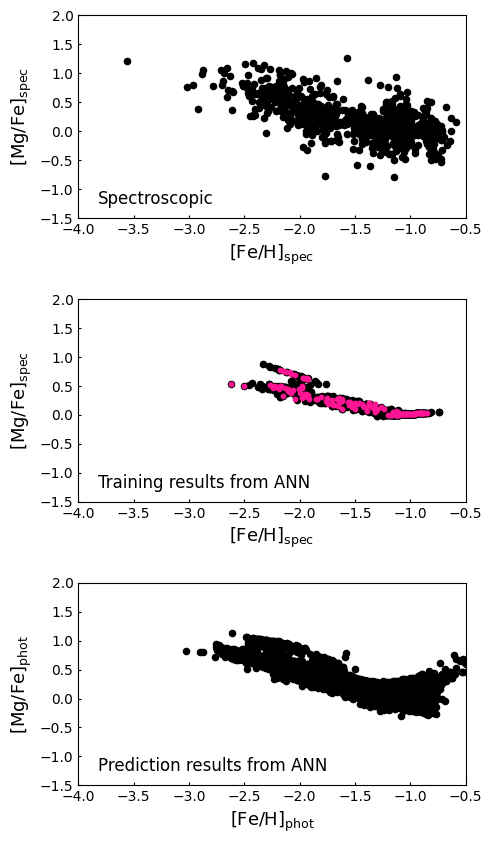

In [68]:
hsc_df_mag_fnx = hsc_df_mag[hsc_df_mag['galaxy_id'] == 0]
hsc_df_mag_scl = hsc_df_mag[hsc_df_mag['galaxy_id'] == 1]
hsc_df_mag_umi = hsc_df_mag[hsc_df_mag['galaxy_id'] == 2]
hsc_df_mag_dra = hsc_df_mag[hsc_df_mag['galaxy_id'] == 3]

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 20 ; alpha = 1

# Spectroscopy
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=s, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, -0.5])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spectroscopic', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(train_dataset_fnx['FEH_phot_ann'], train_dataset_fnx['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dataset_scl['FEH_phot_ann'], train_dataset_scl['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dataset_umi['FEH_phot_ann'], train_dataset_umi['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(train_dataset_dra['FEH_phot_ann'], train_dataset_dra['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax1.scatter(test_dataset_fnx['FEH_phot_ann'], test_dataset_fnx['MGFE_phot_ann'], s=10, alpha=alpha, color='deeppink')
ax1.scatter(test_dataset_scl['FEH_phot_ann'], test_dataset_scl['MGFE_phot_ann'], s=10, alpha=alpha, color='deeppink')
ax1.scatter(test_dataset_umi['FEH_phot_ann'], test_dataset_umi['MGFE_phot_ann'], s=10, alpha=alpha, color='deeppink')
ax1.scatter(test_dataset_dra['FEH_phot_ann'], test_dataset_dra['MGFE_phot_ann'], s=10, alpha=alpha, color='deeppink')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, -0.5])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from ANN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_df_mag_fnx['FEH_phot_ann'], hsc_df_mag_fnx['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_df_mag_scl['FEH_phot_ann'], hsc_df_mag_scl['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_df_mag_umi['FEH_phot_ann'], hsc_df_mag_umi['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.scatter(hsc_df_mag_dra['FEH_phot_ann'], hsc_df_mag_dra['MGFE_phot_ann'], s=s, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, -0.5])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Prediction results from ANN', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

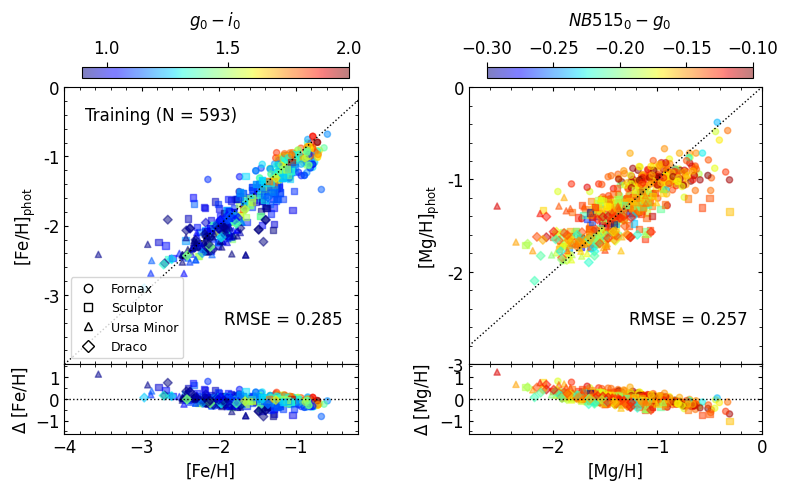

In [69]:
train_dataset_fnx = train_dataset[train_dataset['galaxy_id'] == 0]
train_dataset_scl = train_dataset[train_dataset['galaxy_id'] == 1]
train_dataset_umi = train_dataset[train_dataset['galaxy_id'] == 2]
train_dataset_dra = train_dataset[train_dataset['galaxy_id'] == 3]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 20
alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', 'D']

ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(train_dataset_fnx['FEH'], train_dataset_fnx['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_fnx['Mg0']-train_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(train_dataset_scl['FEH'], train_dataset_scl['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_scl['Mg0']-train_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(train_dataset_umi['FEH'], train_dataset_umi['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_umi['Mg0']-train_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(train_dataset_dra['FEH'], train_dataset_dra['FEH_phot_ann'], s=s, alpha=alpha, c=train_dataset_dra['Mg0']-train_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
ax0.legend(handles=custom_legend, loc='lower left', fontsize=9, framealpha=0.8)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.text(0.07, 0.93, 'Training (N = {0:,.0f})'.format(len(train_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12)
#ax0.text(0.07, 0.85, 'Test (N = {0:,.0f})'.format(len(test_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12, color=color)
ax0.text(0.95, 0.13, f'RMSE = {rmse_train_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color='black')
#ax0.text(0.95, 0.05, f'RMSE = {rmse_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color=color)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$g_0 - i_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(train_dataset_fnx['FEH'], train_dataset_fnx['FEH_phot_ann']-train_dataset_fnx['FEH'], s=s, alpha=alpha, c=train_dataset_fnx['Mg0']-train_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(train_dataset_scl['FEH'], train_dataset_scl['FEH_phot_ann']-train_dataset_scl['FEH'], s=s, alpha=alpha, c=train_dataset_scl['Mg0']-train_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(train_dataset_umi['FEH'], train_dataset_umi['FEH_phot_ann']-train_dataset_umi['FEH'], s=s, alpha=alpha, c=train_dataset_umi['Mg0']-train_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(train_dataset_dra['FEH'], train_dataset_dra['FEH_phot_ann']-train_dataset_dra['FEH'], s=s, alpha=alpha, c=train_dataset_dra['Mg0']-train_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.6, 1.6])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax2.text(0.4, 0.95, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_train_pred_FEH - Y_train_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10)
#ax2.text(0.4, 0.80, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_pred_FEH - Y_test_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10, color=color)

xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(train_dataset_fnx['MGH'], train_dataset_fnx['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_fnx['Mn0']-train_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(train_dataset_scl['MGH'], train_dataset_scl['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_scl['Mn0']-train_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(train_dataset_umi['MGH'], train_dataset_umi['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_umi['Mn0']-train_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(train_dataset_dra['MGH'], train_dataset_dra['MGH_phot_ann'], s=s, alpha=alpha, c=train_dataset_dra['Mn0']-train_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-3, -2, -1, 0])
ax1.set_yticklabels(['-3', '-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.text(0.95, 0.13, f'RMSE = {rmse_train_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color='black')
#ax1.text(0.95, 0.05, f'RMSE = {rmse_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color=color)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$NB515_0 - g_0$', size=12, labelpad=10, loc='center')
#cbar.ax.set_xticks([1.0, 1.5, 2.0])
#cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(train_dataset_fnx['MGH'], train_dataset_fnx['MGH_phot_ann']-train_dataset_fnx['MGH'], s=s, alpha=alpha, c=train_dataset_fnx['Mn0']-train_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(train_dataset_scl['MGH'], train_dataset_scl['MGH_phot_ann']-train_dataset_scl['MGH'], s=s, alpha=alpha, c=train_dataset_scl['Mn0']-train_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(train_dataset_umi['MGH'], train_dataset_umi['MGH_phot_ann']-train_dataset_umi['MGH'], s=s, alpha=alpha, c=train_dataset_umi['Mn0']-train_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(train_dataset_dra['MGH'], train_dataset_dra['MGH_phot_ann']-train_dataset_dra['MGH'], s=s, alpha=alpha, c=train_dataset_dra['Mn0']-train_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.6, 1.6])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()
#plt.savefig('feh_mgh_mgfe_train_pred_test_pred_compare.png', bbox_inches='tight')

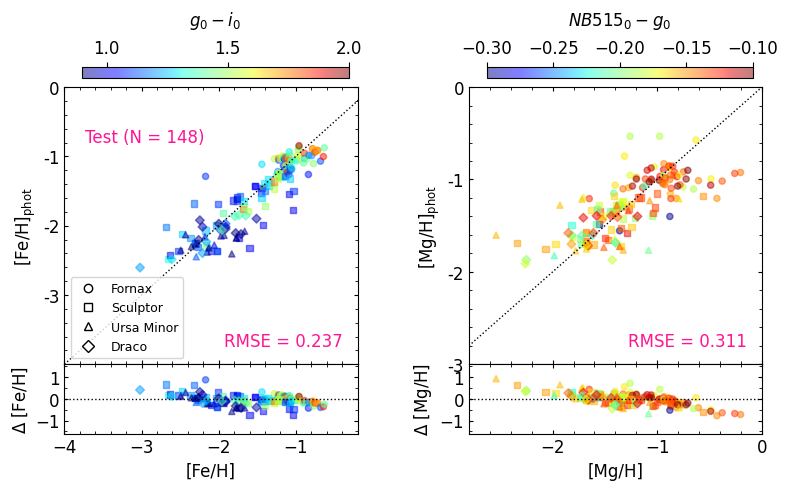

In [70]:
test_dataset_fnx = test_dataset[test_dataset['galaxy_id'] == 0]
test_dataset_scl = test_dataset[test_dataset['galaxy_id'] == 1]
test_dataset_umi = test_dataset[test_dataset['galaxy_id'] == 2]
test_dataset_dra = test_dataset[test_dataset['galaxy_id'] == 3]

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(9, 4.5), gridspec_kw={'wspace':0.38, 'hspace':0, 'height_ratios': [1, 0.25]})
s = 20
alpha = 0.5
xmin, xmax = -4, -0.2
vmin, vmax = 0.9, 2
color = 'deeppink'
markers = ['o', 's', '^', 'D']

ax0.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax0.scatter(test_dataset_fnx['FEH'], test_dataset_fnx['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_fnx['Mg0']-test_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax0.scatter(test_dataset_scl['FEH'], test_dataset_scl['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_scl['Mg0']-test_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax0.scatter(test_dataset_umi['FEH'], test_dataset_umi['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_umi['Mg0']-test_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax0.scatter(test_dataset_dra['FEH'], test_dataset_dra['FEH_phot_ann'], s=s, alpha=alpha, c=test_dataset_dra['Mg0']-test_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
custom_legend = [
    Line2D([0], [0], linestyle='None', marker=markers[0], color='k', markerfacecolor='w', markersize=6, label='Fornax'),
    Line2D([0], [0], linestyle='None', marker=markers[1], color='k', markerfacecolor='w', markersize=6, label='Sculptor'),
    Line2D([0], [0], linestyle='None', marker=markers[2], color='k', markerfacecolor='w', markersize=6, label='Ursa Minor'),
    Line2D([0], [0], linestyle='None', marker=markers[3], color='k', markerfacecolor='w', markersize=6, label='Draco'),
]
ax0.legend(handles=custom_legend, loc='lower left', fontsize=9, framealpha=0.8)
ax0.set_xlabel('')
ax0.set_ylabel('[Fe/H]$_\mathrm{phot}$', size=12)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([xmin, xmax])
ax0.set_xticklabels('')
ax0.set_yticks([-3, -2, -1, 0])
ax0.set_yticklabels(['-3', '-2', '-1', '0'])
ax0.xaxis.set_minor_locator(AutoMinorLocator(5))
ax0.yaxis.set_minor_locator(AutoMinorLocator(5))
ax0.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax0.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax0.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax0.text(0.07, 0.93, 'Training (N = {0:,.0f})'.format(len(train_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.07, 0.85, 'Test (N = {0:,.0f})'.format(len(test_dataset)), ha='left', va='top', transform=ax0.transAxes, size=12, color=color)
#ax0.text(0.95, 0.13, f'RMSE = {rmse_train_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color='black')
ax0.text(0.95, 0.05, f'RMSE = {rmse_FEH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax0.transAxes, color=color)
cax = fig.add_axes([ax0.get_position().x0+0.02, ax0.get_position().y1+0.02, ax0.get_position().x1-ax0.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$g_0 - i_0$', size=12, labelpad=10, loc='center')
cbar.ax.set_xticks([1.0, 1.5, 2.0])
cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax2.axhline(0, xmin, xmax+2, color='k', linewidth=1, linestyle=':')
ax2.scatter(test_dataset_fnx['FEH'], test_dataset_fnx['FEH_phot_ann']-test_dataset_fnx['FEH'], s=s, alpha=alpha, c=test_dataset_fnx['Mg0']-test_dataset_fnx['Mi0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax2.scatter(test_dataset_scl['FEH'], test_dataset_scl['FEH_phot_ann']-test_dataset_scl['FEH'], s=s, alpha=alpha, c=test_dataset_scl['Mg0']-test_dataset_scl['Mi0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax2.scatter(test_dataset_umi['FEH'], test_dataset_umi['FEH_phot_ann']-test_dataset_umi['FEH'], s=s, alpha=alpha, c=test_dataset_umi['Mg0']-test_dataset_umi['Mi0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax2.scatter(test_dataset_dra['FEH'], test_dataset_dra['FEH_phot_ann']-test_dataset_dra['FEH'], s=s, alpha=alpha, c=test_dataset_dra['Mg0']-test_dataset_dra['Mi0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax2.set_xlabel('[Fe/H]', size=12)
ax2.set_ylabel('$\Delta$ [Fe/H]', size=12)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([-1.6, 1.6])
ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
ax2.yaxis.set_minor_locator(AutoMinorLocator(2))
ax2.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax2.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax2.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax2.text(0.4, 0.95, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_train_pred_FEH - Y_train_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10)
#ax2.text(0.4, 0.80, '<$\Delta$ [Fe/H]> = {0:,.3f}'.format(np.mean(Y_pred_FEH - Y_test_FEH)), ha='left', va='top', transform=ax3.transAxes, size=10, color=color)

xmin, xmax = -2.8, 0
vmin, vmax = -0.3, -0.1
ax1.plot(np.arange(xmin, xmax+0.5, 0.1), np.arange(xmin, xmax+0.5, 0.1), color='k', linewidth=1, linestyle=':')
im = ax1.scatter(test_dataset_fnx['MGH'], test_dataset_fnx['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_fnx['Mn0']-test_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax1.scatter(test_dataset_scl['MGH'], test_dataset_scl['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_scl['Mn0']-test_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax1.scatter(test_dataset_umi['MGH'], test_dataset_umi['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_umi['Mn0']-test_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax1.scatter(test_dataset_dra['MGH'], test_dataset_dra['MGH_phot_ann'], s=s, alpha=alpha, c=test_dataset_dra['Mn0']-test_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax1.set_xlabel('')
ax1.set_ylabel('[Mg/H]$_\mathrm{phot}$', size=12)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([xmin, xmax])
ax1.set_xticklabels('')
ax1.set_yticks([-3, -2, -1, 0])
ax1.set_yticklabels(['-3', '-2', '-1', '0'])
ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax1.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax1.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
#ax1.text(0.95, 0.13, f'RMSE = {rmse_train_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color='black')
ax1.text(0.95, 0.05, f'RMSE = {rmse_MGH:.3f}', fontsize=12, ha='right', va='bottom', transform=ax1.transAxes, color=color)
cax = fig.add_axes([ax1.get_position().x0+0.02, ax1.get_position().y1+0.02, ax1.get_position().x1-ax1.get_position().x0-0.03, 0.025])
cbar = fig.colorbar(im, orientation='horizontal', cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$NB515_0 - g_0$', size=12, labelpad=10, loc='center')
#cbar.ax.set_xticks([1.0, 1.5, 2.0])
#cbar.ax.set_xticklabels(['1.0', '1.5', '2.0'])

ax3.axhline(0, xmin, xmax+1, color='k', linewidth=1, linestyle=':')
ax3.scatter(test_dataset_fnx['MGH'], test_dataset_fnx['MGH_phot_ann']-test_dataset_fnx['MGH'], s=s, alpha=alpha, c=test_dataset_fnx['Mn0']-test_dataset_fnx['Mg0'], cmap='jet', marker=markers[0], vmin=vmin, vmax=vmax)
ax3.scatter(test_dataset_scl['MGH'], test_dataset_scl['MGH_phot_ann']-test_dataset_scl['MGH'], s=s, alpha=alpha, c=test_dataset_scl['Mn0']-test_dataset_scl['Mg0'], cmap='jet', marker=markers[1], vmin=vmin, vmax=vmax)
ax3.scatter(test_dataset_umi['MGH'], test_dataset_umi['MGH_phot_ann']-test_dataset_umi['MGH'], s=s, alpha=alpha, c=test_dataset_umi['Mn0']-test_dataset_umi['Mg0'], cmap='jet', marker=markers[2], vmin=vmin, vmax=vmax)
ax3.scatter(test_dataset_dra['MGH'], test_dataset_dra['MGH_phot_ann']-test_dataset_dra['MGH'], s=s, alpha=alpha, c=test_dataset_dra['Mn0']-test_dataset_dra['Mg0'], cmap='jet', marker=markers[3], vmin=vmin, vmax=vmax)
ax3.set_xlabel('[Mg/H]', size=12)
ax3.set_ylabel('$\Delta$ [Mg/H]', size=12)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([-1.6, 1.6])
ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
ax3.yaxis.set_minor_locator(AutoMinorLocator(2))
ax3.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
ax3.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3, labelsize=12)
ax3.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

plt.show()
#plt.savefig('feh_mgh_mgfe_train_pred_test_pred_compare.png', bbox_inches='tight')

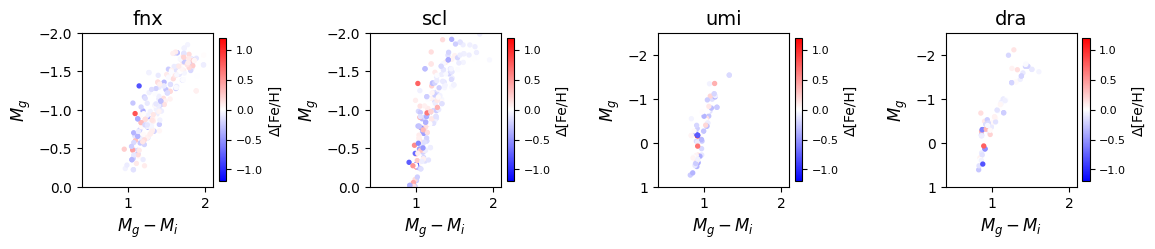

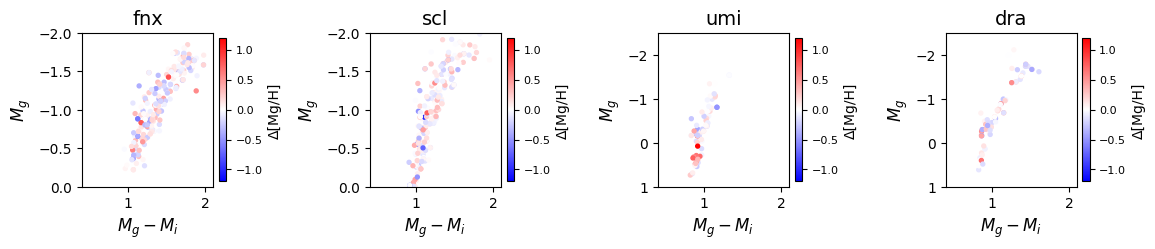

In [78]:
datasets = {
    "fnx": {"data": train_dataset_fnx, "ymin": -2, "ymax": 0},
    "scl": {"data": train_dataset_scl, "ymin": -2, "ymax": 0},
    "umi": {"data": train_dataset_umi, "ymin": -2.5, "ymax": 1},
    "dra": {"data": train_dataset_dra, "ymin": -2.5, "ymax": 1},
}

s = 8 ; alpha = 1
vmin, vmax = -1.2, 1.2
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(13, 2), gridspec_kw={'wspace': 1.0})

for ax, (name, info) in zip(axes, datasets.items()):
    df = info["data"]
    ymin, ymax = info["ymin"], info["ymax"]
    df["FEH_diff"] = df["FEH_phot_ann"] - df["FEH"]

    im = ax.scatter(df["Mg0"]-df["Mi0"], df["Mg0"], marker='o', s=s, c=df["FEH_diff"], cmap='bwr', vmin=vmin, vmax=vmax, alpha=alpha)
    ax.set_xlim([0.4, 2.1])
    ax.set_ylim([ymax, ymin])
    ax.set_xlabel("$M_g - M_i$", size=12)
    ax.set_ylabel("$M_g$", size=12)
    ax.set_title(f"{name}", size=14)
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.05, pad=0.04)
    cbar.set_label("Δ[Fe/H]", size=10)
    cbar.ax.tick_params(labelsize=8)

plt.show()


datasets = {
    "fnx": {"data": train_dataset_fnx, "ymin": -2, "ymax": 0},
    "scl": {"data": train_dataset_scl, "ymin": -2, "ymax": 0},
    "umi": {"data": train_dataset_umi, "ymin": -2.5, "ymax": 1},
    "dra": {"data": train_dataset_dra, "ymin": -2.5, "ymax": 1},
}

s = 8 ; alpha = 1
vmin, vmax = -1.2, 1.2
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(13, 2), gridspec_kw={'wspace': 1.0})

for ax, (name, info) in zip(axes, datasets.items()):
    df = info["data"]
    ymin, ymax = info["ymin"], info["ymax"]
    df["MGH_diff"] = df["MGH_phot_ann"] - df["MGH"]

    im = ax.scatter(df["Mg0"]-df["Mi0"], df["Mg0"], marker='o', s=s, c=df["MGH_diff"], cmap='bwr', vmin=vmin, vmax=vmax, alpha=alpha)
    ax.set_xlim([0.4, 2.1])
    ax.set_ylim([ymax, ymin])
    ax.set_xlabel("$M_g - M_i$", size=12)
    ax.set_ylabel("$M_g$", size=12)
    ax.set_title(f"{name}", size=14)
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.05, pad=0.04)
    cbar.set_label("Δ[Mg/H]", size=10)
    cbar.ax.tick_params(labelsize=8)

plt.show()

In [21]:
%%time
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import layers
from sklearn.metrics import r2_score
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

## HSC-DEIMOS -> HSC (Fnx+Scl+UMi+Dra)
# Train and predict FEH and MGH
df_mag_ohe = pd.get_dummies(df_mag, columns=['DSPH'])
galaxy_id = 0 * df_mag_ohe['DSPH_for'] + 1 * df_mag_ohe['DSPH_scl'] + 2 * df_mag_ohe['DSPH_umi'] + 3 * df_mag_ohe['DSPH_dra']
df_X = np.column_stack((
    df_mag['Mg0'], 
    df_mag['Mg0'] - df_mag['Mi0'], 
    df_mag['Mg0'] - df_mag['Mn0'], 
    galaxy_id
))
df_Y = np.column_stack((df_mag['FEH'], df_mag['MGH']))
indices = df_mag.index
X_train, X_test, Y_train, Y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=42)
idx_train, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
print('Training sample size =', len(X_train)) #592
print('Test sample size =', len(X_test), '\n') #149

#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)


def build_model():
    model = keras.Sequential([
        keras.layers.Dense(3, activation='relu', input_shape=(4,)),
        keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(2)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 5000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=500)

# Note that the input only takes the first three columns
history = model.fit(train_dataset.iloc[:,:3], train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
model.save("model.h5")
    
test_predictions = model.predict(test_dataset.iloc[:,:3])
print(test_dataset)
test_dataset['Predicted Nu'], test_dataset['Predicted CD'] = test_predictions[:,0], test_predictions[:,1]
print("\nPredicted\n")
print(test_dataset)



from tensorflow.keras.regularizers import l2
# Define ANN model
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Y_predict = classifier.predict(X_test)
Y_predict = (Y_predict > 0.5)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, Y_predict)

"""
# Error of test sample
Y_pred = model.predict(X_test)
test_err_FEH = df_mag.loc[idx_test, 'FEHERR']
test_err_MGH = df_mag.loc[idx_test, 'MGHERR']
pd.set_option('display.float_format', '{:.15f}'.format)
print('test_err_FEH : {0:.3f}'.format(test_err_FEH.mean())) #0.104
print('test_err_MGH : {0:.3f}'.format(test_err_MGH.mean())) #0.234
# rmse of test sample
mse_FEH = mean_squared_error(Y_test[:, 0], Y_pred[:, 0])
mse_MGH = mean_squared_error(Y_test[:, 1], Y_pred[:, 1])
rmse_FEH = math.sqrt(mse_FEH)
rmse_MGH = math.sqrt(mse_MGH)
print('rmse_FEH of test results : {0:.3f}'.format(rmse_FEH)) #0.
print('rmse_MGH of test results : {0:.3f}'.format(rmse_MGH)) #0.
# calculate chi-square of test sample
Y_pred_uncertainty = np.std(Y_pred, axis=0)
chi_sq_test_FEH = np.sum((Y_pred[:, 0] - Y_test[:, 0])**2 / (test_err_FEH**2 + Y_pred_uncertainty[0]**2))  / len(Y_test[:, 0])
chi_sq_test_MGH = np.sum((Y_pred[:, 1] - Y_test[:, 1])**2 / (test_err_MGH**2 + Y_pred_uncertainty[1]**2))  / len(Y_test[:, 1])
print('chi_sq_test_FEH : {0:.3f}'.format(chi_sq_test_FEH)) #0.
print('chi_sq_test_MGH : {0:.3f}'.format(chi_sq_test_MGH)) #1.
print('mean Y_pred_FEH_uncertainty :{0:.3f}'.format(Y_pred_uncertainty[0])) #0.
print('mean Y_pred_MGH_uncertainty :{0:.3f}'.format(Y_pred_uncertainty[1])) #0.
print('\n')

# Error of training sample
Y_train_pred = model.predict(X_train)
train_err_FEH = df_mag.loc[idx_train, 'FEHERR']
train_err_MGH = df_mag.loc[idx_train, 'MGHERR']
print('train_err_FEH : {0:.3f}'.format(train_err_FEH.mean())) #0.105
print('train_err_MGH : {0:.3f}'.format(train_err_MGH.mean())) #0.222
# rmse of training sample
mse_train_FEH = mean_squared_error(Y_train[:, 0], Y_train_pred[:, 0])
mse_train_MGH = mean_squared_error(Y_train[:, 1], Y_train_pred[:, 1])
rmse_train_FEH = math.sqrt(mse_train_FEH)
rmse_train_MGH = math.sqrt(mse_train_MGH)
print('rmse_train_FEH of training results : {0:.3f}'.format(rmse_train_FEH)) #0.
print('rmse_train_MGH of training results : {0:.3f}'.format(rmse_train_MGH)) #0.
# Calculate chi-square of training sample
Y_train_pred_uncertainty = np.std(Y_train_pred, axis=0)
chi_sq_training_FEH = np.sum((Y_train_pred[:, 0] - Y_train[:, 0])**2 / (train_err_FEH**2 + Y_train_pred_uncertainty[0]**2)) / len(Y_train[:, 0])
chi_sq_training_MGH = np.sum((Y_train_pred[:, 1] - Y_train[:, 1])**2 / (train_err_MGH**2 + Y_train_pred_uncertainty[1]**2)) / len(Y_train[:, 1])
print('chi_sq_training_FEH : {0:.3f}'.format(chi_sq_training_FEH)) #0.
print('chi_sq_training_MGH : {0:.3f}'.format(chi_sq_training_MGH)) #0.
print('mean Y_train_pred_FEH_uncertainty :{0:.3f}'.format(Y_train_pred_uncertainty[0])) #0.
print('mean Y_train_pred_MGH_uncertainty :{0:.3f}'.format(Y_train_pred_uncertainty[1])) #0.
print('\n')

## Fitting to the HSC data
hsc_df_mag_ohe = pd.get_dummies(hsc_df_mag, columns=['name'])
hsc_galaxy_id = 0 * hsc_df_mag_ohe['name_for'] + 1 * hsc_df_mag_ohe['name_scl'] + 2 * hsc_df_mag_ohe['name_umi'] + 3 * hsc_df_mag_ohe['name_dra']
hsc_df_X = np.column_stack((
    hsc_df_mag['Mg0'], 
    hsc_df_mag['Mg0']-hsc_df_mag['Mi0'],
    hsc_df_mag['Mg0']-hsc_df_mag['Mn0'],
    hsc_galaxy_id
))

def predict_with_uncertainty(model, X, n_iter=100):
    predictions = np.zeros((n_iter, X.shape[0], 2))

    for i in range(n_iter):
        predictions[i] = model(X, training=True).numpy()

    pred_mean = predictions.mean(axis=0)
    pred_std = predictions.std(axis=0)
    
    return pred_mean, pred_std

n_iter = 100
pred_mean, pred_std = predict_with_uncertainty(model, hsc_df_X, n_iter)
hsc_df_mag['FEH_phot_ann'] = pred_mean[:, 0]
hsc_df_mag['MGH_phot_ann'] = pred_mean[:, 1]
hsc_df_mag['FEH_phot_ann_uncertainty'] = pred_std[:, 0]
hsc_df_mag['MGH_phot_ann_uncertainty'] = pred_std[:, 1]
print('mean FEH_phot_ann_uncertainty :{0:.3f}'.format(hsc_df_mag['FEH_phot_ann_uncertainty'].mean())) #0.180
print('mean MGH_phot_ann_uncertainty :{0:.3f}'.format(hsc_df_mag['MGH_phot_ann_uncertainty'].mean())) #0.136

print('len(hsc_df_mag) =', len(hsc_df_mag)) #9318
print(Counter(hsc_df_mag['name']), '\n') #Counter({'for': 7251, 'scl': 1132, 'umi': 593, 'dra': 342}) 

# ---------------------------------------------------------------------------------------------------------------------------------
# Train and predict MGFE
for i in range(6):
    hsc_df_mag['MGFE_phot_ann'] = hsc_df_mag['MGH_phot_ann'] - hsc_df_mag['FEH_phot_ann']
    hsc_df_mag['MGFE_phot_ann_uncertainty'] = np.sqrt(np.abs(hsc_df_mag['MGH_phot_ann_uncertainty']**2 - hsc_df_mag['FEH_phot_ann_uncertainty']**2))

# Re-call each galaxy's name
hsc_fnx_mag = hsc_df_mag[hsc_df_mag['name'] == 'for']
hsc_scl_mag = hsc_df_mag[hsc_df_mag['name'] == 'scl']
hsc_umi_mag = hsc_df_mag[hsc_df_mag['name'] == 'umi']
hsc_dra_mag = hsc_df_mag[hsc_df_mag['name'] == 'dra']
"""

Training sample size = 592
Test sample size = 149 

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6200 - loss: 0.6583
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6202 - loss: 0.5333
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5915 - loss: 0.4120
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6167 - loss: 0.2918
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6329 - loss: 0.1650
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6344 - loss: 0.0347
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6086 - loss: -0.0434
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6552 - loss: -0.1588
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6476 - loss: -0.3215
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6127 - loss: -0.3772
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6650 - loss: -0.5772
Epoch 

ValueError: Classification metrics can't handle a mix of continuous-multioutput and multilabel-indicator targets

In [ ]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(5,10), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 30 ; alpha = 0.2

# Spectroscopy
#ax0.errorbar(fnx_mag['FEH'], fnx_mag['MGFE'], xerr=fnx_mag['FEHERR'], yerr=fnx_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='gray')
#ax0.errorbar(scl_mag['FEH'], scl_mag['MGFE'], xerr=scl_mag['FEHERR'], yerr=scl_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='mediumorchid')
#ax0.errorbar(umi_mag['FEH'], umi_mag['MGFE'], xerr=umi_mag['FEHERR'], yerr=umi_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='darkorange')
#ax0.errorbar(dra_mag['FEH'], dra_mag['MGFE'], xerr=dra_mag['FEHERR'], yerr=dra_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='lightseagreen')
ax0.scatter(fnx_mag['FEH'], fnx_mag['MGFE'], s=3, alpha=alpha, color='black')
ax0.scatter(scl_mag['FEH'], scl_mag['MGFE'], s=3, alpha=alpha, color='black')
ax0.scatter(umi_mag['FEH'], umi_mag['MGFE'], s=3, alpha=alpha, color='black')
ax0.scatter(dra_mag['FEH'], dra_mag['MGFE'], s=3, alpha=alpha, color='black')
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, -0.5])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.05, 0.05, 'Spectroscopic (training+test)', ha='left', va='bottom', transform=ax0.transAxes, color='k', size=12)

# Training
ax1.scatter(Y_train_pred, Y_train_pred, s=3, alpha=alpha, color='black')
#ax1.scatter(Y_pred, Y_pred, s=3, alpha=0.4, color='red')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax1.set_xlim([-4, -0.5])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.text(0.05, 0.05, 'Training results from ANN', ha='left', va='bottom', transform=ax1.transAxes, color='k', size=12)

# Photometry
ax2.scatter(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], s=3, alpha=alpha, color='black')
ax2.scatter(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], s=3, alpha=alpha, color='black')
ax2.scatter(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], s=3, alpha=alpha, color='black')
ax2.scatter(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], s=3, alpha=alpha, color='black')
ax2.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax2.set_xlim([-4, -0.5])
ax2.set_ylim([-1.5, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.05, 0.05, 'Prediction results from ANN', ha='left', va='bottom', transform=ax2.transAxes, color='k', size=12)

plt.show()

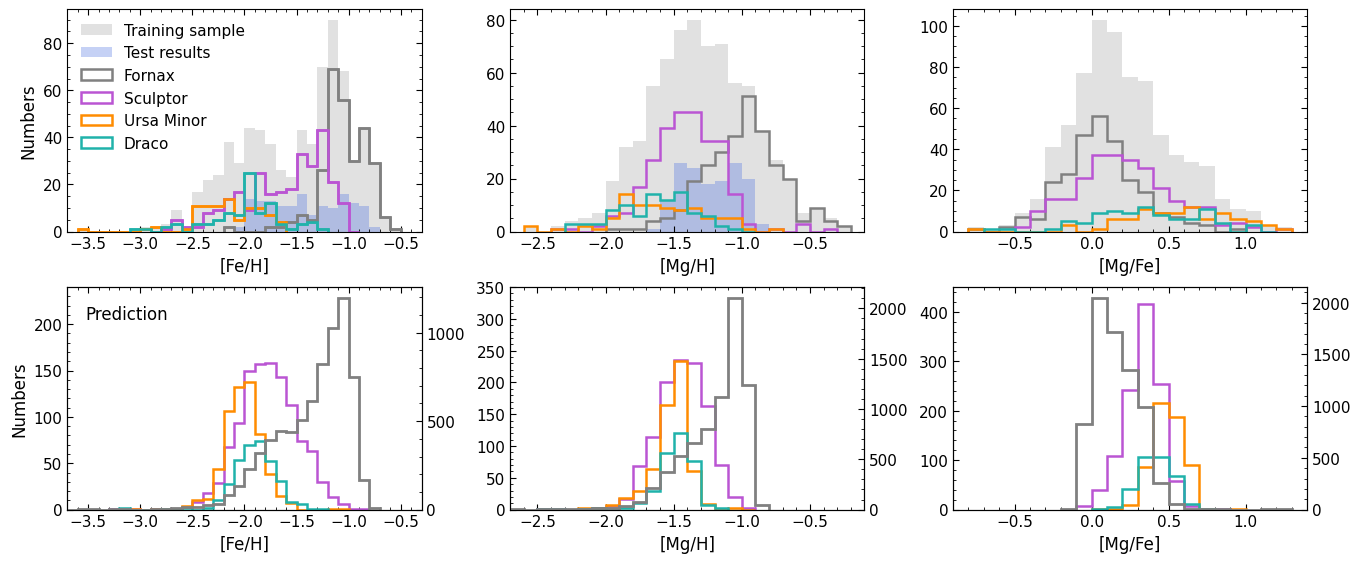

In [59]:
from matplotlib.ticker import MultipleLocator

def plot_histogram(ax, data_list, labels, colors, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    for data, color in zip(data_list, colors):
        ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                histtype='step', linestyle=linestyle, color=color, linewidth=1.8, alpha=1)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    if show_legend:
        for data, label, color in zip(data_list, labels, colors):
            ax.hist(data, bins=np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                    histtype='step', linestyle=linestyle, color=color, label=label, linewidth=1.8, alpha=1)
        ax.legend(loc='upper left', frameon=False, fontsize=11)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)

def plot_with_twinx(ax_twin, ax, twin_data, data_list, twin_label, labels, twin_color, colors, xlabel, ylabel, bins_width=0.1, show_legend=True, linestyle='solid'):
    ax_twin.hist(twin_data, bins=np.arange(np.floor(np.min(twin_data) / bins_width) * bins_width,
                                     np.ceil(np.max(twin_data) / bins_width) * bins_width + bins_width,
                                     bins_width),
                 histtype='step', linestyle=linestyle, color=twin_color, label=twin_label, linewidth=2)
    plot_histogram(ax, data_list, labels, colors, xlabel, ylabel, bins_width, show_legend, linestyle)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    ax.tick_params(axis='y', which='both', left=True, right=False)
    ax_twin.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=11)
    ax_twin.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=11)
    ax_twin.yaxis.set_minor_locator(MultipleLocator(100))
    ax_twin.yaxis.set_major_locator(MultipleLocator(500))
    if show_legend:
        handles, labels = ax.get_legend_handles_labels()
        handles_twin, labels_twin = ax_twin.get_legend_handles_labels()
        ax.legend(handles_twin + handles, labels_twin + labels, loc='upper left', frameon=False, fontsize=10)



# Set up the figure and axes
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 6.5), gridspec_kw={'wspace': 0.25, 'hspace': 0.25})

bins_width = 0.1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']

# 1st row 
ax0.hist(df_mag['FEH'], bins=np.arange(np.floor(np.min(df_mag['FEH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['FEH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2, label='Training sample')
ax0.hist(Y_pred[:, 0], bins=np.arange(np.floor(np.min(Y_pred[:, 0]) / bins_width) * bins_width,
                                     np.ceil(np.max(Y_pred[:, 0]) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3, label='Test results')
plot_histogram(ax0, [fnx_mag['FEH'], scl_mag['FEH'], umi_mag['FEH'], dra_mag['FEH']], labels, colors, '[Fe/H]', 'Numbers')
ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_xlim([-3.7, -0.3])

ax1.hist(df_mag['MGH'], bins=np.arange(np.floor(np.min(df_mag['MGH']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGH']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
ax1.hist(Y_pred[:, 1], bins=np.arange(np.floor(np.min(Y_pred[:, 1]) / bins_width) * bins_width,
                                     np.ceil(np.max(Y_pred[:, 1]) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='royalblue', alpha=0.3)
plot_histogram(ax1, [fnx_mag['MGH'], scl_mag['MGH'], umi_mag['MGH'], dra_mag['MGH']], labels, colors, '[Mg/H]', 'Numbers', show_legend=False)
ax1.set_xlim([-2.7, -0.1])

ax2.hist(df_mag['MGFE'], bins=np.arange(np.floor(np.min(df_mag['MGFE']) / bins_width) * bins_width,
                                     np.ceil(np.max(df_mag['MGFE']) / bins_width) * bins_width + bins_width,
                                     bins_width),
         histtype='stepfilled', color='dimgray', alpha=0.2)
plot_histogram(ax2, [fnx_mag['MGFE'], scl_mag['MGFE'], umi_mag['MGFE'], dra_mag['MGFE']], labels, colors, '[Mg/Fe]', 'Numbers', show_legend=False)
ax2.set_xlim([-0.9, 1.4])

# 2nd row 
plot_with_twinx(ax3.twinx(), ax3, 
                hsc_fnx_mag['FEH_phot_ann'], [hsc_scl_mag['FEH_phot_ann'], hsc_umi_mag['FEH_phot_ann'], hsc_dra_mag['FEH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Fe/H]', 'Numbers', show_legend=False)
ax3.set_ylim([0, 240])
ax3.text(0.05, 0.92, 'Prediction', ha='left', va='top', transform=ax3.transAxes, size=12)
ax3.set_xlim([-3.7, -0.3])

plot_with_twinx(ax4.twinx(), ax4, 
                hsc_fnx_mag['MGH_phot_ann'], [hsc_scl_mag['MGH_phot_ann'], hsc_umi_mag['MGH_phot_ann'], hsc_dra_mag['MGH_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Mg/H]', 'Numbers', show_legend=False)
ax4.set_ylim([0, 350])
ax4.set_xlim([-2.7, -0.1])

plot_with_twinx(ax5.twinx(), ax5, 
                hsc_fnx_mag['MGFE_phot_ann'], [hsc_scl_mag['MGFE_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], hsc_dra_mag['MGFE_phot_ann']], 
                'Fnx prediction', ['Scl prediction', 'UMi prediction', 'Dra prediction'], 
                'gray', ['mediumorchid', 'darkorange', 'lightseagreen'], '[Mg/Fe]', 'Numbers', show_legend=False)
ax5.set_ylim([0, 450])
ax5.set_xlim([-0.9, 1.4])

for ax in [ax1, ax2, ax4, ax5]:
    ax.set_ylabel('')

# Save the plot
plt.savefig('compare_ann_feh_mgh_mgfe.png', bbox_inches='tight')

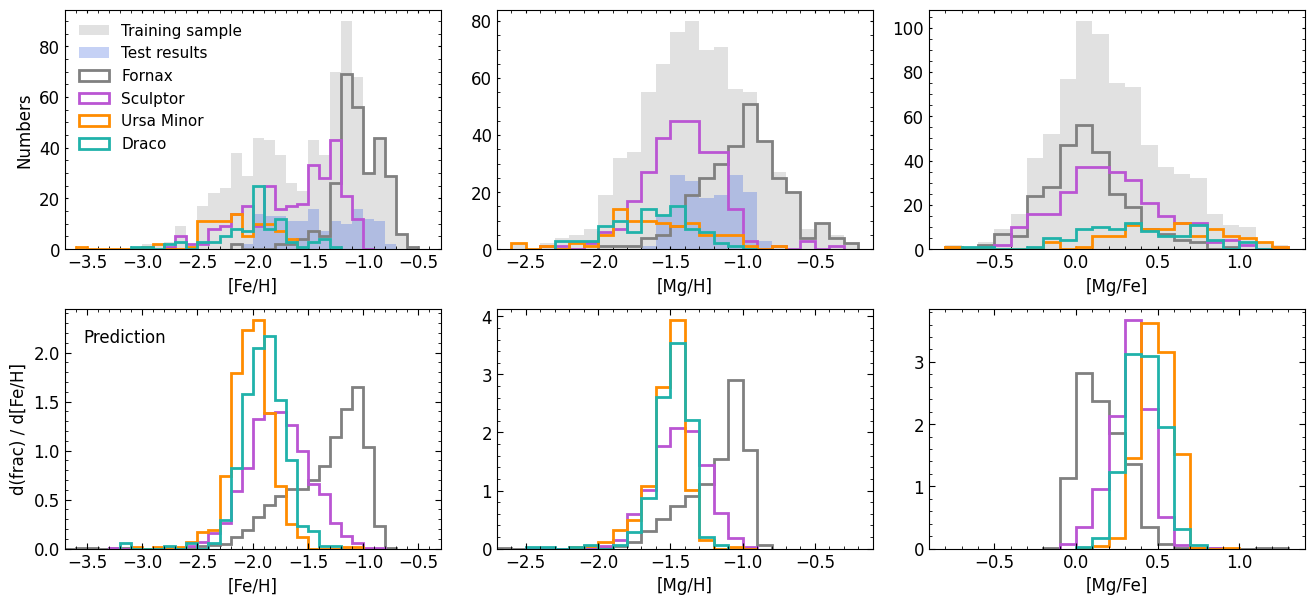

In [61]:
bins_width = 0.1
alpha = 1
labels = ['Fornax', 'Sculptor', 'Ursa Minor', 'Draco']
colors = ['gray', 'mediumorchid', 'darkorange', 'lightseagreen']

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 7), gridspec_kw={'wspace': 0.15, 'hspace': 0.25})

data_dict_feh = {
    'Training sample': (df_mag['FEH'], 'dimgray', 0.2),
    'Test results': (Y_pred[:, 0], 'royalblue', 0.3),
    'Fornax': (fnx_mag['FEH'], colors[0], alpha),
    'Sculptor': (scl_mag['FEH'], colors[1], alpha),
    'Ursa Minor': (umi_mag['FEH'], colors[2], alpha),
    'Draco': (dra_mag['FEH'], colors[3], alpha)
}

data_dict_mgh = {
    'Training sample': (df_mag['MGH'], 'dimgray', 0.2),
    'Test results': (Y_pred[:, 1], 'royalblue', 0.3),
    'Fornax': (fnx_mag['MGH'], colors[0], alpha),
    'Sculptor': (scl_mag['MGH'], colors[1], alpha),
    'Ursa Minor': (umi_mag['MGH'], colors[2], alpha),
    'Draco': (dra_mag['MGH'], colors[3], alpha)
}

data_dict_mgfe = {
    'Training sample': (df_mag['MGFE'], 'dimgray', 0.2),
    'Fornax': (fnx_mag['MGFE'], colors[0], alpha),
    'Sculptor': (scl_mag['MGFE'], colors[1], alpha),
    'Ursa Minor': (umi_mag['MGFE'], colors[2], alpha),
    'Draco': (dra_mag['MGFE'], colors[3], alpha)
}

for data_dict, ax, xlabel in zip(
        [data_dict_feh, data_dict_mgh, data_dict_mgfe],  
        [ax0, ax1, ax2],  
        ['[Fe/H]', '[Mg/H]', '[Mg/Fe]']
):
    for label, (data, color, alpha_value) in data_dict.items():
        bins = np.arange(np.floor(np.min(data) / bins_width) * bins_width, 
                         np.ceil(np.max(data) / bins_width) * bins_width + bins_width, 
                         bins_width)
        ax.hist(data, bins=bins, histtype='step' if label not in ['Training sample', 'Test results'] else 'stepfilled', color=color, alpha=alpha_value, label=label, linewidth=2)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel('')
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=2.5, labelsize=12)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=2.5, labelsize=12)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)

ax0.set_xticks([-3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5])
ax0.set_ylabel('Numbers', size=12)
ax0.legend(loc='upper left', frameon=False, fontsize=11)
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)


def create_data_sets(data_dict, labels, colors):
    return [(data_dict[label], label, color) for label, color in zip(labels, colors)]

data_sets = [
    ('FEH_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag),
    ('MGH_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag),
    ('MGFE_phot_ann', hsc_fnx_mag, hsc_scl_mag, hsc_umi_mag, hsc_dra_mag)
]

data_sets_list = []
for feature in data_sets:
    feature_name, *datasets = feature
    data_sets_list.append(create_data_sets({label: data[feature_name] for label, data in zip(labels, datasets)}, labels, colors))

def plot_histogram(ax, data, bins_width, label, color, alpha=0.8):
    color_dict = {
        'Fornax': 'gray',
        'Sculptor': 'mediumorchid',
        'Ursa Minor': 'darkorange',
        'Draco': 'lightseagreen',
        'Training sample': 'dimgray',
        'Test results': 'royalblue'
    }
    color = color_dict.get(label, 'gray')
    
    bins = np.arange(np.floor(np.min(data) / bins_width) * bins_width,
                     np.ceil(np.max(data) / bins_width) * bins_width + bins_width,
                     bins_width)
    counts, bin_edges = np.histogram(data, bins=bins)
    frac_dfeh = counts / (len(data) * bins_width)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    ax.stairs(frac_dfeh, bin_edges, label=label, color=color, linewidth=2)
    
    return ax

def plot_data_on_ax(ax, data_sets, xlabel, ylabel, xticks=None):
    for data, label, color in data_sets:
        plot_histogram(ax, data, bins_width, label, color, alpha=alpha)
    ax.set_ylim(bottom=0)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=4, labelsize=12)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=4, labelsize=12)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=2, labelsize=12)
    
    if xticks:
        ax.set_xticks(xticks)

data_sets_0 = data_sets_list[0]
data_sets_1 = data_sets_list[1]
data_sets_2 = data_sets_list[2]
plot_data_on_ax(ax3, data_sets_0, '[Fe/H]', 'd(frac) / d[Fe/H]')
plot_data_on_ax(ax4, data_sets_1, '[Mg/H]', '')
plot_data_on_ax(ax5, data_sets_2, '[Mg/Fe]', '', xticks=[-0.5, 0.0, 0.5, 1.0])
ax3.text(0.05, 0.92, 'Prediction', ha='left', va='top', transform=ax3.transAxes, size=12)

ax0.set_xlim([-3.7, -0.3])
ax1.set_xlim([-2.7, -0.1])
ax2.set_xlim([-0.9, 1.4])
ax3.set_xlim([-3.7, -0.3])
ax4.set_xlim([-2.7, -0.1])
ax5.set_xlim([-0.9, 1.4])

plt.savefig('compare_ann_feh_mgh_mgfe_dfrac_dfeh.png', bbox_inches='tight')

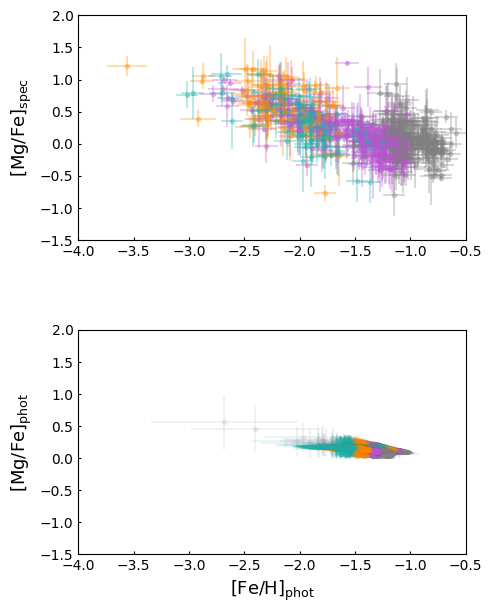

In [15]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(5,7), gridspec_kw={'wspace':0.4, 'hspace':0.4})
s = 12
alpha = 0.3

# Spectroscopy
ax0.errorbar(fnx_mag['FEH'], fnx_mag['MGFE'], xerr=fnx_mag['FEHERR'], yerr=fnx_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='gray')
ax0.errorbar(scl_mag['FEH'], scl_mag['MGFE'], xerr=scl_mag['FEHERR'], yerr=scl_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='mediumorchid')
ax0.errorbar(umi_mag['FEH'], umi_mag['MGFE'], xerr=umi_mag['FEHERR'], yerr=umi_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='darkorange')
ax0.errorbar(dra_mag['FEH'], dra_mag['MGFE'], xerr=dra_mag['FEHERR'], yerr=dra_mag['MGFEERR'], markersize=3, fmt='o', alpha=0.3, color='lightseagreen')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=13)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=13)
ax0.set_xlim([-4, -0.5])
ax0.set_ylim([-1.5, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)

# Photometry
ax1.errorbar(hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], xerr=hsc_fnx_mag['FEH_phot_ann_uncertainty'], yerr=hsc_fnx_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='gray')
ax1.errorbar(hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], xerr=hsc_scl_mag['FEH_phot_ann_uncertainty'], yerr=hsc_scl_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='mediumorchid')
ax1.errorbar(hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], xerr=hsc_umi_mag['FEH_phot_ann_uncertainty'], yerr=hsc_umi_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='darkorange')
ax1.errorbar(hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], xerr=hsc_dra_mag['FEH_phot_ann_uncertainty'], yerr=hsc_dra_mag['MGFE_phot_ann_uncertainty'], markersize=3, fmt='o', alpha=0.1, color='lightseagreen')
ax1.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=13)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=13)
ax1.set_xlim([-4, -0.5])
ax1.set_ylim([-1.5, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)

#plt.show()
plt.savefig('compare_ann_spec_phot_mgfe_feh_together.png', bbox_inches='tight')

In [68]:
predicted_fnx_FEH = slope_fnx * fnx_mag['FEH'] + intercept_fnx
predicted_hsc_fnx_FEH = slope_hsc_fnx * hsc_fnx_mag['FEH_phot_ann'] + intercept_hsc_fnx
predicted_scl_FEH = slope_scl * scl_mag['FEH'] + intercept_scl
predicted_hsc_scl_FEH = slope_hsc_scl * hsc_scl_mag['FEH_phot_ann'] + intercept_hsc_scl
predicted_umi_FEH = slope_umi * umi_mag['FEH'] + intercept_umi
predicted_hsc_umi_FEH = slope_hsc_umi * hsc_umi_mag['FEH_phot_ann'] + intercept_hsc_umi
predicted_dra_FEH = slope_dra * dra_mag['FEH'] + intercept_dra
predicted_hsc_dra_FEH = slope_hsc_dra * hsc_dra_mag['FEH_phot_ann'] + intercept_hsc_dra

predicted_fnx_MGFE = slope_fnx * fnx_mag['MGFE'] + intercept_fnx
predicted_hsc_fnx_MGFE = slope_hsc_fnx * hsc_fnx_mag['MGFE_phot_ann'] + intercept_hsc_fnx
predicted_scl_MGFE = slope_scl * scl_mag['MGFE'] + intercept_scl
predicted_hsc_scl_MGFE = slope_hsc_scl * hsc_scl_mag['MGFE_phot_ann'] + intercept_hsc_scl
predicted_umi_MGFE = slope_umi * umi_mag['MGFE'] + intercept_umi
predicted_hsc_umi_MGFE = slope_hsc_umi * hsc_umi_mag['MGFE_phot_ann'] + intercept_hsc_umi
predicted_dra_MGFE = slope_dra * dra_mag['MGFE'] + intercept_dra
predicted_hsc_dra_MGFE = slope_hsc_dra * hsc_dra_mag['MGFE_phot_ann'] + intercept_hsc_dra

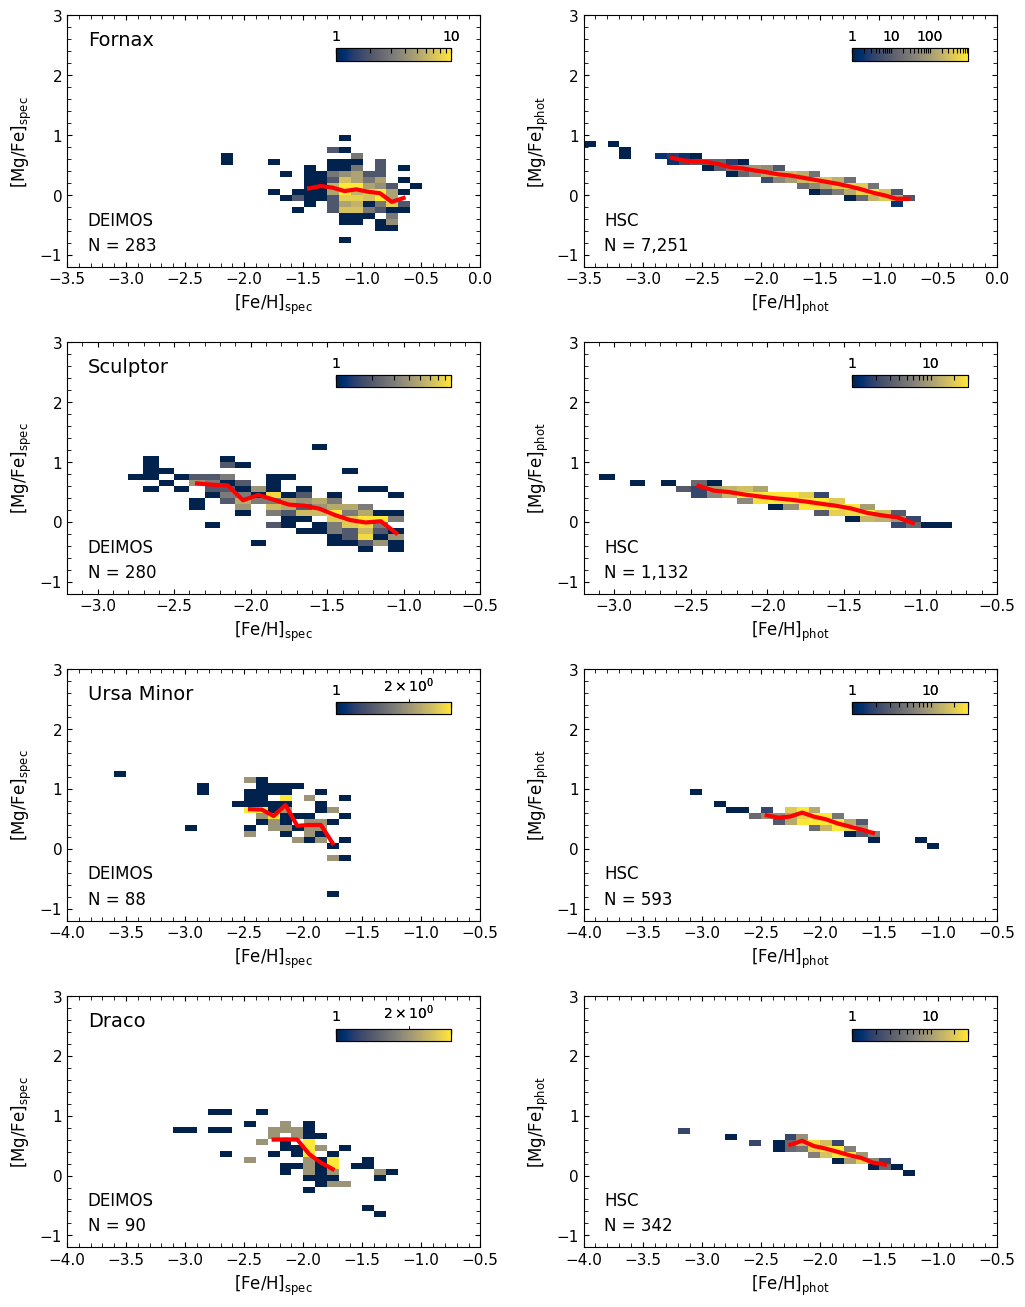

In [69]:
def plot_2d_histogram(ax, x, y, xlabel, ylabel, xlim, ylim, vmin=None, vmax=None, ticks=None):
    bins_width = 0.1
    xbins = np.arange(np.floor(np.min(x) / bins_width) * bins_width, 
                      np.ceil(np.max(x) / bins_width) * bins_width + bins_width, bins_width)
    ybins = np.arange(np.floor(np.min(y) / bins_width) * bins_width, 
                      np.ceil(np.max(y) / bins_width) * bins_width + bins_width, bins_width)

    counts, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins))

    median_values = []
    for i in range(len(xedges) - 1):
        mask = (xedges[i] <= x) & (x < xedges[i+1])
        y_in_bin = y[mask]
        if len(y_in_bin) >= 5:
            median_values.append(np.median(y_in_bin))
        else:
            median_values.append(np.nan)

    xedges_centered = (xedges[:-1] + xedges[1:]) / 2
    median_values = median_values[:len(xedges_centered)]

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    im = ax.imshow(counts.T, cmap='cividis', origin='lower', extent=extent, aspect='auto', norm=LogNorm(vmin=vmin, vmax=vmax))
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel, size=12)
    ax.set_ylabel(ylabel, size=12)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.tick_params(axis='x', which='major', direction='in', right=True, top=True, length=3.5, labelsize=11)
    ax.tick_params(axis='x', which='minor', direction='in', right=True, top=True, length=3, labelsize=11)
    ax.tick_params(axis='y', which='major', direction='in', right=True, top=True, length=3.5, labelsize=11)
    ax.tick_params(axis='y', which='minor', direction='in', right=True, top=True, length=3, labelsize=11)
    
    # Plot median line
    ax.plot(xedges_centered, median_values, color='red', label='Median', lw=3)

    # Add color bar
    cax = ax.inset_axes([0.65, 0.82, 0.28, 0.05])
    fig.add_axes(cax)
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.ax.tick_params(labelsize=10, direction='in')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label('', size=11, labelpad=4, loc='center')
    cbar.locator = LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=5)
    cbar.formatter = LogFormatter(base=10.0, labelOnlyBase=True)
    if ticks:
        cbar.set_ticks(ticks)  # Add custom ticks
    cbar.update_ticks()

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16), gridspec_kw={'wspace': 0.25, 'hspace': 0.3})
(ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7) = axes

# Fornax
plot_2d_histogram(ax0, fnx_mag['FEH'], fnx_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-3.5, 0], [-1.2, 3], vmin=1, vmax=10)
plot_2d_histogram(ax1, hsc_fnx_mag['FEH_phot_ann'], hsc_fnx_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-3.5, 0], [-1.2, 3])
ax0.text(0.05, 0.94, 'Fornax', ha='left', va='top', transform=ax0.transAxes, size=14)
ax0.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(fnx_mag['FEH'])), ha='left', va='bottom', transform=ax0.transAxes, size=12)
ax1.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax1.transAxes, size=12)
ax1.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_fnx_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax1.transAxes, size=12)

# Sculptor
plot_2d_histogram(ax2, scl_mag['FEH'], scl_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-3.2, -0.5], [-1.2, 3])
plot_2d_histogram(ax3, hsc_scl_mag['FEH_phot_ann'], hsc_scl_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-3.2, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax2.text(0.05, 0.94, 'Sculptor', ha='left', va='top', transform=ax2.transAxes, size=14)
ax2.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax2.transAxes, size=12)
ax2.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(scl_mag['FEH'])), ha='left', va='bottom', transform=ax2.transAxes, size=12)
ax3.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax3.transAxes, size=12)
ax3.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_scl_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax3.transAxes, size=12)

# Ursa Minor
plot_2d_histogram(ax4, umi_mag['FEH'], umi_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=3, ticks=[1, 3])
plot_2d_histogram(ax5, hsc_umi_mag['FEH_phot_ann'], hsc_umi_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax4.text(0.05, 0.94, 'Ursa Minor', ha='left', va='top', transform=ax4.transAxes, size=14)
ax4.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax4.transAxes, size=12)
ax4.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(umi_mag['FEH'])), ha='left', va='bottom', transform=ax4.transAxes, size=12)
#cbar.set_ticks([1, 3])
ax5.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax5.transAxes, size=12)
ax5.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_umi_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax5.transAxes, size=12)

# Draco
plot_2d_histogram(ax6, dra_mag['FEH'], dra_mag['MGFE'], r'[Fe/H]$_\mathrm{spec}$', r'[Mg/Fe]$_\mathrm{spec}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=3, ticks=[1, 3])
plot_2d_histogram(ax7, hsc_dra_mag['FEH_phot_ann'], hsc_dra_mag['MGFE_phot_ann'], r'[Fe/H]$_\mathrm{phot}$', r'[Mg/Fe]$_\mathrm{phot}$', [-4, -0.5], [-1.2, 3], vmin=1, vmax=30)
ax6.text(0.05, 0.94, 'Draco', ha='left', va='top', transform=ax6.transAxes, size=14)
ax6.text(0.05, 0.15, 'DEIMOS', ha='left', va='bottom', transform=ax6.transAxes, size=12)
ax6.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(dra_mag['FEH'])), ha='left', va='bottom', transform=ax6.transAxes, size=12)
ax7.text(0.05, 0.15, 'HSC', ha='left', va='bottom', transform=ax7.transAxes, size=12)
ax7.text(0.05, 0.05, 'N = {0:,.0f}'.format(len(hsc_dra_mag['FEH_phot_ann'])), ha='left', va='bottom', transform=ax7.transAxes, size=12)


plt.savefig('compare_ann_spec_phot_mgfe_feh_hist2d_medianline.png', bbox_inches='tight')

In [70]:
def get_median_mgfe(feh_values, mgfe_values, bin_width=0.1):
    bins = np.arange(np.floor(np.min(feh_values) / bin_width) * bin_width, 
                     np.ceil(np.max(feh_values) / bin_width) * bin_width + bin_width, bin_width)
    #print(bins) #[-2.2 -2.1 -2. -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1. -0.9 -0.8 -0.7 -0.6 -0.5]
    
    median_mgfe_dict = {}
    for i in range(len(bins) - 1):
        mask = (bins[i] <= feh_values) & (feh_values < bins[i + 1])
        if np.sum(mask) >= 5:  # get median value if there are 5 data at least
            median_mgfe_dict[(bins[i], bins[i + 1])] = np.median(mgfe_values[mask])
        else:
            median_mgfe_dict[(bins[i], bins[i + 1])] = np.nan  # NaN if there are less than 5 stars
    
    return median_mgfe_dict

# Get median MGFE value per FEH 0.1 bin
median_mgfe_bins = get_median_mgfe(fnx_mag['FEH'], fnx_mag['MGFE'])

# Get predicted MGFE values
# Assign the median MGFE value of the corresponding FEH bin as the predicted value for each data point.
predicted_fnx_MGFE = np.array([
    median_mgfe_bins.get(
        next(((b1, b2) for (b1, b2) in median_mgfe_bins if b1 <= feh < b2), None),
        np.nan
    ) for feh in fnx_mag['FEH']
])
#print(predicted_fnx_MGFE)

"""def calculate_err_sys(mgfe, fitted_mgfe, err_mgfe, N):
    def equation(err_sys):
        #numerator = np.sum((mgfe - fitted_mgfe)**2)
        #denominator = np.sum(err_mgfe**2) + (err_sys**2)
        numerator = (mgfe - fitted_mgfe)**2
        denominator = err_mgfe**2 + err_sys**2
        result = np.sum(numerator / denominator) / N
        print(f"numerator: {numerator}, denominator: {denominator}, result: {result}")
        
        return result - 1
   
    err_sys_initial = 0.1
    err_sys_solution = fsolve(equation, err_sys_initial)[0]
    print('err_sys_solution =', np.abs(err_sys_solution))

    return err_sys_solution

err_sys_1 = calculate_err_sys(fnx_mag['MGFE'], predicted_fnx_MGFE, fnx_mag['MGFEERR'], len(fnx_mag['MGFE']))

err_sys_2 = calculate_err_sys(hsc_fnx_mag['MGFE_phot_ann'], predicted_hsc_fnx_MGFE, hsc_fnx_mag['MGFE_phot_ann_uncertainty'], len(hsc_fnx_mag['MGFE_phot_ann']))
"""

from scipy.optimize import minimize
def calculate_err_sys(mgfe, fitted_mgfe, err_mgfe, N):
    def objective(err_sys):
        numerator = (mgfe - fitted_mgfe)**2
        denominator = err_mgfe**2 + err_sys[0]**2
        result = np.sum(numerator / denominator) / N
        #print(f"numerator: {numerator}, denominator: {denominator}, result: {result}")
        return (result - 1)**2  #minimize

    initial_guess = [0.1]
    bounds = [(0, None)]
    
    result = minimize(objective, x0=initial_guess, bounds=bounds)
    
    err_sys_solution = result.x[0]
    print(f"err_sys_solution: {err_sys_solution}")
    return err_sys_solution

sys_err_fnx = calculate_err_sys(fnx_mag['MGFE'], predicted_fnx_MGFE, fnx_mag['MGFEERR'], len(fnx_mag['MGFE']))
sys_err_hsc_fnx = calculate_err_sys(hsc_fnx_mag['MGFE_phot_ann'], predicted_hsc_fnx_MGFE, hsc_fnx_mag['MGFE_phot_ann_uncertainty'], len(hsc_fnx_mag['MGFE_phot_ann']))

err_sys_solution: 0.14317656398425804
err_sys_solution: 0.5881356520195343


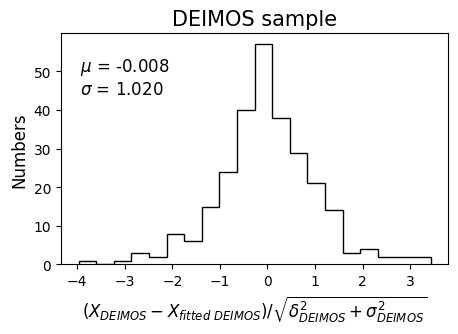

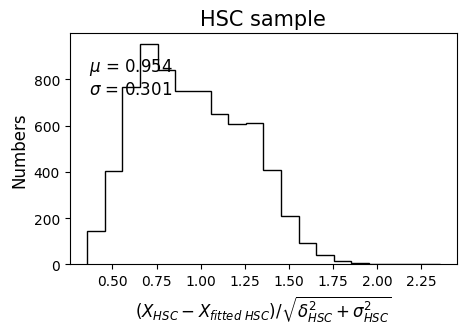

In [71]:
fig, ax0 = plt.subplots(figsize=(5,3))
x = (fnx_mag['MGFE'] - predicted_fnx_MGFE) / np.sqrt(fnx_mag['MGFEERR']**2 + sys_err_fnx**2)
ax0.hist(x, bins=20, color='k', histtype='step')
ax0.set_title('DEIMOS sample', size=15)
ax0.set_xlabel(r'$(X_{DEIMOS} - X_{fitted~DEIMOS}) / \sqrt{\delta_{DEIMOS}^2 + \sigma_{DEIMOS}^2}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.text(0.05, 0.9, '$\mu$ = {0:,.3f}'.format(np.mean(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.8, '$\sigma$ = {0:,.3f}'.format(np.std(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
plt.show()

print('\n')

fig, ax0 = plt.subplots(figsize=(5,3))
x = (hsc_fnx_mag['MGFE_phot_ann'] - predicted_hsc_fnx_MGFE) / np.sqrt(hsc_fnx_mag['MGFE_phot_ann_uncertainty']**2 + sys_err_hsc_fnx**2)
ax0.hist(x, bins=20, color='k', histtype='step')
ax0.set_title('HSC sample', size=15)
ax0.set_xlabel(r'$(X_{HSC} - X_{fitted~HSC}) / \sqrt{\delta_{HSC}^2 + \sigma_{HSC}^2}$', size=12)
ax0.set_ylabel('Numbers', size=12)
ax0.text(0.05, 0.9, '$\mu$ = {0:,.3f}'.format(np.mean(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
ax0.text(0.05, 0.8, '$\sigma$ = {0:,.3f}'.format(np.std(x)), ha='left', va='top', transform=ax0.transAxes, size=12)
plt.show()

In [73]:
fnx_mag_sigma = fnx_mag[
(np.abs(fnx_mag['FEH'] - np.mean(fnx_mag['FEH'])) - fnx_mag['FEHERR'] < 3 * fnx_mag['FEHERR'])
&
(np.abs(fnx_mag['MGFE'] - np.mean(fnx_mag['MGFE'])) - fnx_mag['MGFEERR'] < 3 * fnx_mag['MGFEERR'])
]
print(len(fnx_mag)) #261
print(len(fnx_mag_sigma), '\n') #224
scl_mag_sigma = scl_mag[
(np.abs(scl_mag['FEH'] - np.mean(scl_mag['FEH'])) - scl_mag['FEHERR'] < 3 * scl_mag['FEHERR'])
&
(np.abs(scl_mag['MGFE'] - np.mean(scl_mag['MGFE'])) - scl_mag['MGFEERR'] < 3 * scl_mag['MGFEERR'])
]
print(len(scl_mag)) #294
print(len(scl_mag_sigma), '\n') #184
umi_mag_sigma = umi_mag[
(np.abs(umi_mag['FEH'] - np.mean(umi_mag['FEH'])) - umi_mag['FEHERR'] < 3 * umi_mag['FEHERR'])
&
(np.abs(umi_mag['MGFE'] - np.mean(umi_mag['MGFE'])) - umi_mag['MGFEERR'] < 3 * umi_mag['MGFEERR'])
]
print(len(umi_mag)) #91
print(len(umi_mag_sigma), '\n') #74
dra_mag_sigma = dra_mag[
(np.abs(dra_mag['FEH'] - np.mean(dra_mag['FEH'])) - dra_mag['FEHERR'] < 3 * dra_mag['FEHERR'])
&
(np.abs(dra_mag['MGFE'] - np.mean(dra_mag['MGFE'])) - dra_mag['MGFEERR'] < 3 * dra_mag['MGFEERR'])
]
print(len(dra_mag)) #108
print(len(dra_mag_sigma), '\n') #82


hsc_fnx_mag_sigma = hsc_fnx_mag[
(np.abs(hsc_fnx_mag['FEH_phot_ann'] - np.mean(hsc_fnx_mag['FEH_phot_ann'])) - hsc_fnx_mag['FEH_phot_ann_uncertainty'] < 3 * hsc_fnx_mag['FEH_phot_ann_uncertainty'])
&
(np.abs(hsc_fnx_mag['MGFE_phot_ann'] - np.mean(hsc_fnx_mag['MGFE_phot_ann'])) - hsc_fnx_mag['MGFE_phot_ann_uncertainty'] < 3 * hsc_fnx_mag['MGFE_phot_ann_uncertainty'])
]
print(len(hsc_fnx_mag)) #5514
print(len(hsc_fnx_mag_sigma), '\n') #5364
hsc_scl_mag_sigma = hsc_scl_mag[
(np.abs(hsc_scl_mag['FEH_phot_ann'] - np.mean(hsc_scl_mag['FEH_phot_ann'])) - hsc_scl_mag['FEH_phot_ann_uncertainty'] < 3 * hsc_scl_mag['FEH_phot_ann_uncertainty'])
&
(np.abs(hsc_scl_mag['MGFE_phot_ann'] - np.mean(hsc_scl_mag['MGFE_phot_ann'])) - hsc_scl_mag['MGFE_phot_ann_uncertainty'] < 3 * hsc_scl_mag['MGFE_phot_ann_uncertainty'])
]
print(len(hsc_scl_mag)) #1205
print(len(hsc_scl_mag_sigma), '\n') #1078
hsc_umi_mag_sigma = hsc_umi_mag[
(np.abs(hsc_umi_mag['FEH_phot_ann'] - np.mean(hsc_umi_mag['FEH_phot_ann'])) - hsc_umi_mag['FEH_phot_ann_uncertainty'] < 3 * hsc_umi_mag['FEH_phot_ann_uncertainty'])
&
(np.abs(hsc_umi_mag['MGFE_phot_ann'] - np.mean(hsc_umi_mag['MGFE_phot_ann'])) - hsc_umi_mag['MGFE_phot_ann_uncertainty'] < 3 * hsc_umi_mag['MGFE_phot_ann_uncertainty'])
]
print(len(hsc_umi_mag)) #647
print(len(hsc_umi_mag_sigma), '\n') #630
hsc_dra_mag_sigma = hsc_dra_mag[
(np.abs(hsc_dra_mag['FEH_phot_ann'] - np.mean(hsc_dra_mag['FEH_phot_ann'])) - hsc_dra_mag['FEH_phot_ann_uncertainty'] < 3 * hsc_dra_mag['FEH_phot_ann_uncertainty'])
&
(np.abs(hsc_dra_mag['MGFE_phot_ann'] - np.mean(hsc_dra_mag['MGFE_phot_ann'])) - hsc_dra_mag['MGFE_phot_ann_uncertainty'] < 3 * hsc_dra_mag['MGFE_phot_ann_uncertainty'])
]
print(len(hsc_dra_mag)) #469
print(len(hsc_dra_mag_sigma)) #444

283
235 

280
169 

88
70 

90
64 

7251
6826 

1132
1100 

593
591 

342
339


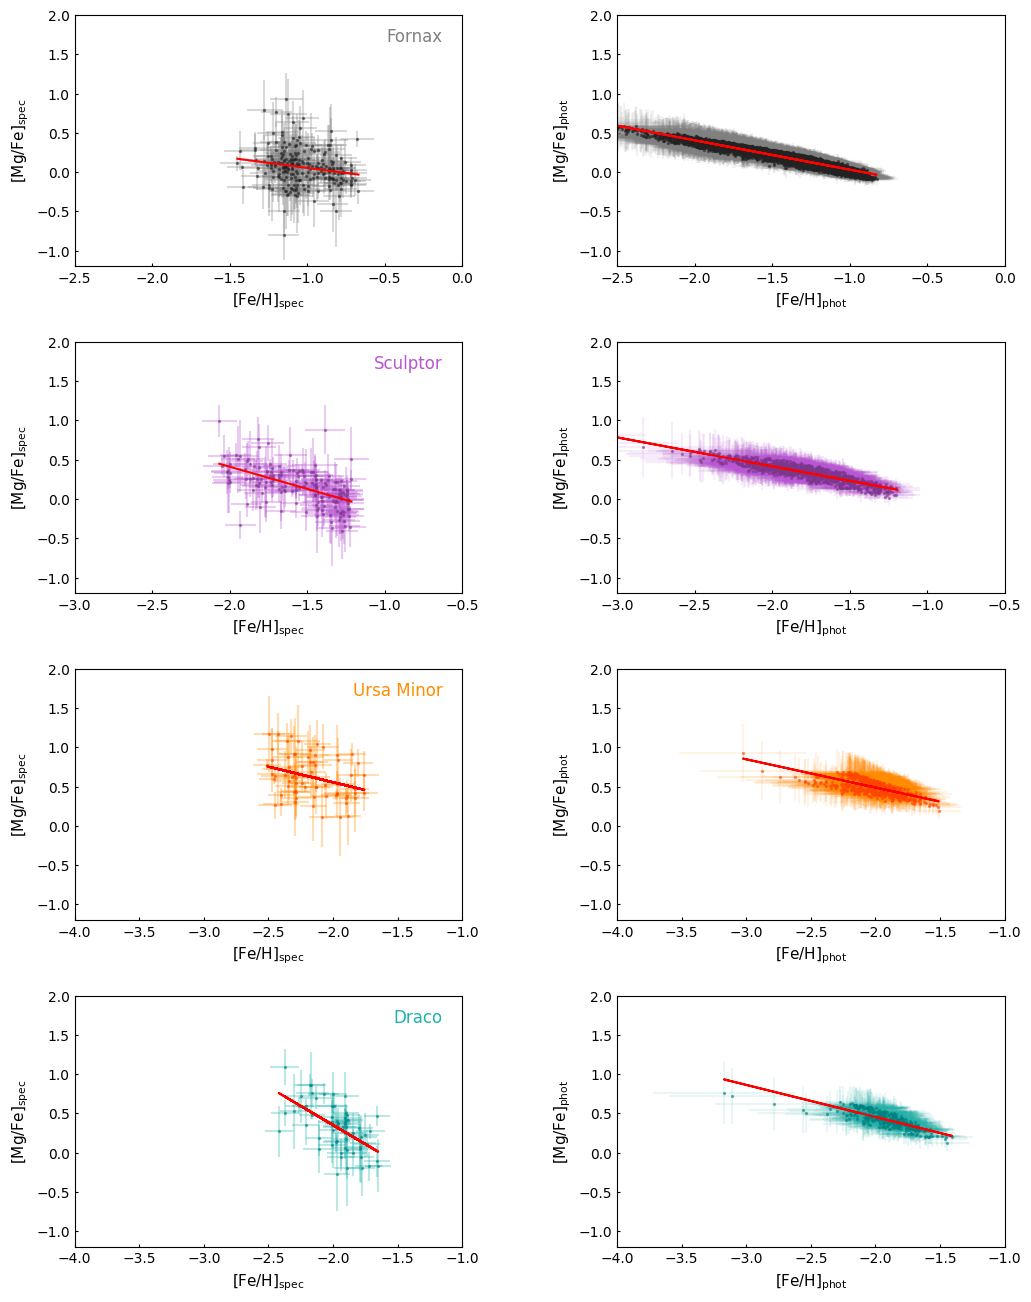

In [76]:
# Spec MGFE - FEH vs. phot MGFE - FEH
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(12,16), gridspec_kw={'wspace':0.4, 'hspace':0.3})
s = 2 ; alpha = 0.5 ; markersize=0

# Fnx
ax0.errorbar(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], xerr=fnx_mag_sigma['FEHERR'], yerr=fnx_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='gray')
ax0.scatter(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#222222', zorder=2)
ax0.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax0.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax0.set_xlim([-2.5, 0])
ax0.set_ylim([-1.2, 2])
ax0.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax0.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax0.text(0.95, 0.95, 'Fornax', ha='right', va='top', transform=ax0.transAxes, color='gray', size=12)
slope, intercept = np.polyfit(fnx_mag_sigma['FEH'], fnx_mag_sigma['MGFE'], 1)
ax0.plot(fnx_mag_sigma['FEH'], slope * fnx_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax1.errorbar(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], xerr=hsc_fnx_mag_sigma['FEH_phot_ann_uncertainty'], yerr=hsc_fnx_mag_sigma['MGFE_phot_ann_uncertainty'], markersize=markersize, fmt='o', alpha=0.1, color='gray')
ax1.scatter(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#222222', zorder=2)
ax1.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax1.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax1.set_xlim([-2.5, 0])
ax1.set_ylim([-1.2, 2])
ax1.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax1.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax1.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_fnx_mag_sigma['FEH_phot_ann'], hsc_fnx_mag_sigma['MGFE_phot_ann'], 1)
ax1.plot(hsc_fnx_mag_sigma['FEH_phot_ann'], slope * hsc_fnx_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# Scl
ax2.errorbar(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], xerr=scl_mag_sigma['FEHERR'], yerr=scl_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='mediumorchid')
ax2.scatter(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#7A378B', zorder=2)
ax2.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax2.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax2.set_xlim([-3, -0.5])
ax2.set_ylim([-1.2, 2])
ax2.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax2.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax2.text(0.95, 0.95, 'Sculptor', ha='right', va='top', transform=ax2.transAxes, color='mediumorchid', size=12)
slope, intercept = np.polyfit(scl_mag_sigma['FEH'], scl_mag_sigma['MGFE'], 1)
ax2.plot(scl_mag_sigma['FEH'], slope * scl_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax3.errorbar(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], xerr=hsc_scl_mag_sigma['FEH_phot_ann_uncertainty'], yerr=hsc_scl_mag_sigma['MGFE_phot_ann_uncertainty'], markersize=markersize, fmt='o', alpha=0.1, color='mediumorchid')
ax3.scatter(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#7A378B', zorder=2)
ax3.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax3.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax3.set_xlim([-3, -0.5])
ax3.set_ylim([-1.2, 2])
ax3.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax3.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax3.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax3.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_scl_mag_sigma['FEH_phot_ann'], hsc_scl_mag_sigma['MGFE_phot_ann'], 1)
ax3.plot(hsc_scl_mag_sigma['FEH_phot_ann'], slope * hsc_scl_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# UMi
ax4.errorbar(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], xerr=umi_mag_sigma['FEHERR'], yerr=umi_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='darkorange')
ax4.scatter(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#FF4500', zorder=2)
ax4.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax4.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax4.set_xlim([-4, -1])
ax4.set_ylim([-1.2, 2])
ax4.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax4.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax4.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax4.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax4.text(0.95, 0.95, 'Ursa Minor', ha='right', va='top', transform=ax4.transAxes, color='darkorange', size=12)
slope, intercept = np.polyfit(umi_mag_sigma['FEH'], umi_mag_sigma['MGFE'], 1)
ax4.plot(umi_mag_sigma['FEH'], slope * umi_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax5.errorbar(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], xerr=hsc_umi_mag_sigma['FEH_phot_ann_uncertainty'], yerr=hsc_umi_mag_sigma['MGFE_phot_ann_uncertainty'], markersize=markersize, fmt='o', alpha=0.1, color='darkorange')
ax5.scatter(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#FF4500', zorder=2)
ax5.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax5.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax5.set_xlim([-4, -1])
ax5.set_ylim([-1.2, 2])
ax5.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax5.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax5.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax5.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_umi_mag_sigma['FEH_phot_ann'], hsc_umi_mag_sigma['MGFE_phot_ann'], 1)
ax5.plot(hsc_umi_mag_sigma['FEH_phot_ann'], slope * hsc_umi_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')


# Dra
ax6.errorbar(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], xerr=dra_mag_sigma['FEHERR'], yerr=dra_mag_sigma['MGFEERR'], markersize=markersize, fmt='o', alpha=0.3, color='lightseagreen')
ax6.scatter(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], s=s, alpha=alpha, marker='o', color='#008080', zorder=2)
ax6.set_xlabel(r'[Fe/H]$_\mathrm{spec}$', size=11)
ax6.set_ylabel(r'[Mg/Fe]$_\mathrm{spec}$', size=11)
ax6.set_xlim([-4, -1])
ax6.set_ylim([-1.2, 2])
ax6.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax6.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax6.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax6.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax6.text(0.95, 0.95, 'Draco', ha='right', va='top', transform=ax6.transAxes, color='lightseagreen', size=12)
slope, intercept = np.polyfit(dra_mag_sigma['FEH'], dra_mag_sigma['MGFE'], 1)
ax6.plot(dra_mag_sigma['FEH'], slope * dra_mag_sigma['FEH'] + intercept, color='red', lw=1.5, label='Trendline')

ax7.errorbar(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], xerr=hsc_dra_mag_sigma['FEH_phot_ann_uncertainty'], yerr=hsc_dra_mag_sigma['MGFE_phot_ann_uncertainty'], markersize=markersize, fmt='o', alpha=0.1, color='lightseagreen')
ax7.scatter(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], s=s, alpha=alpha, marker='o', color='#008080', zorder=2)
ax7.set_xlabel(r'[Fe/H]$_\mathrm{phot}$', size=11)
ax7.set_ylabel(r'[Mg/Fe]$_\mathrm{phot}$', size=11)
ax7.set_xlim([-4, -1])
ax7.set_ylim([-1.2, 2])
ax7.tick_params(axis='x', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax7.tick_params(axis='x', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
ax7.tick_params(axis='y', which='major', direction='in', right=False, top=False, length=2.5, labelsize=10)
ax7.tick_params(axis='y', which='minor', direction='in', right=False, top=False, length=2, labelsize=10)
slope, intercept = np.polyfit(hsc_dra_mag_sigma['FEH_phot_ann'], hsc_dra_mag_sigma['MGFE_phot_ann'], 1)
ax7.plot(hsc_dra_mag_sigma['FEH_phot_ann'], slope * hsc_dra_mag_sigma['FEH_phot_ann'] + intercept, color='red', lw=1.5, label='Trendline')

#plt.show()
plt.savefig('compare_ann_spec_phot_mgfe_feh_w_line.png', bbox_inches='tight')

In [ ]:
# Simple comparison version

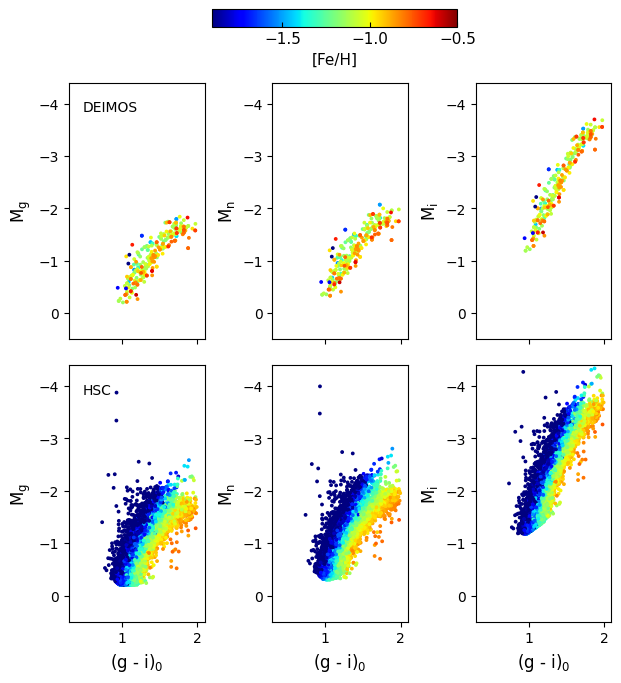

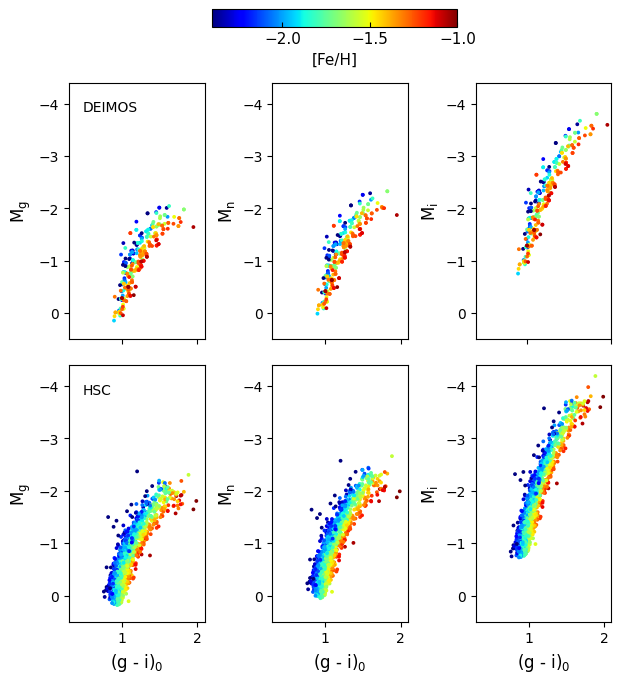

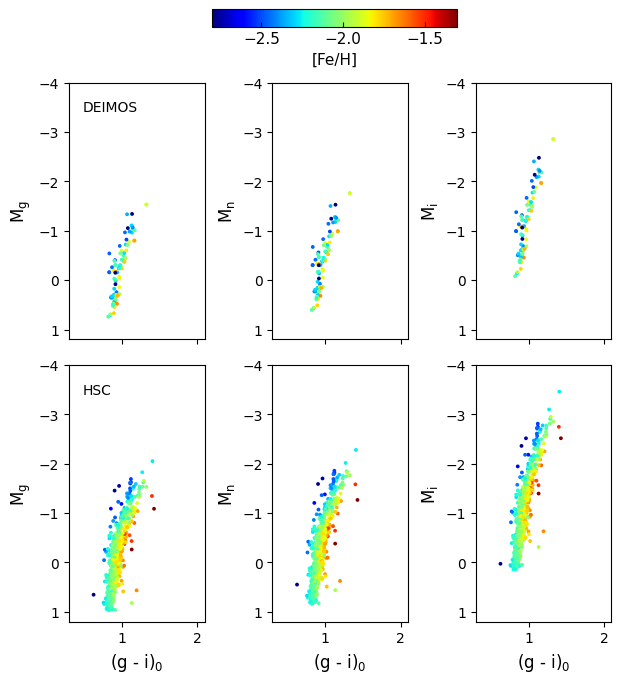

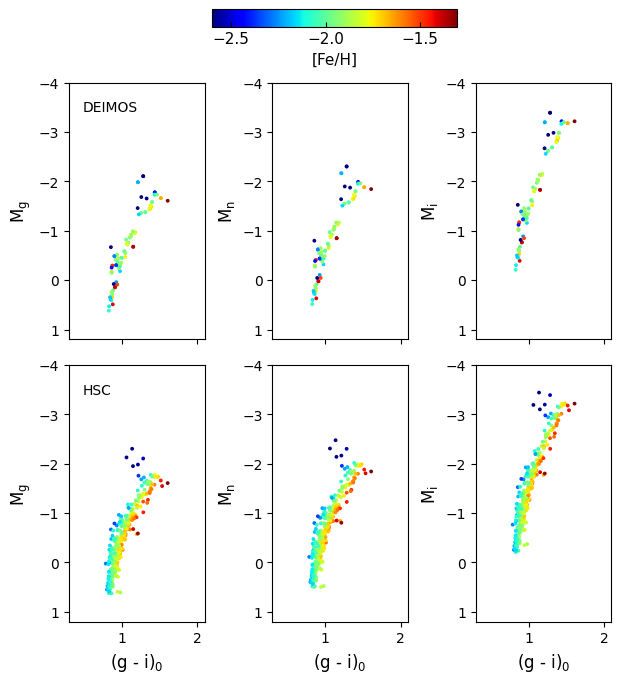

In [77]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.8 ; vmax = -1.3
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.6 ; vmax = -1.3
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Fe/H]', size=11)
plt.savefig('cmd_deimos_hsc_feh_Draco.png', bbox_inches='tight')

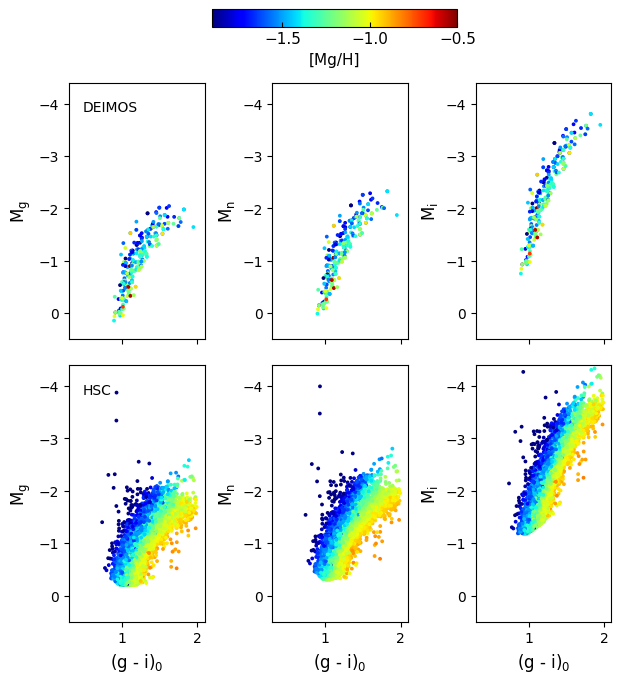

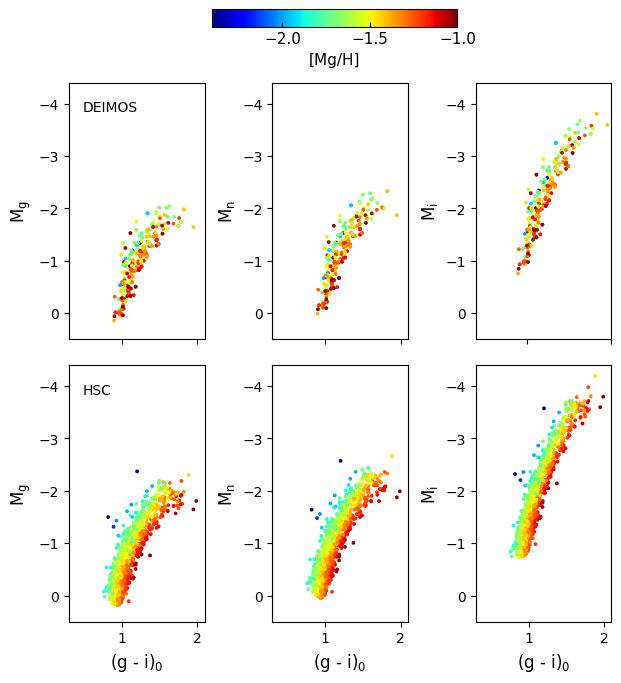

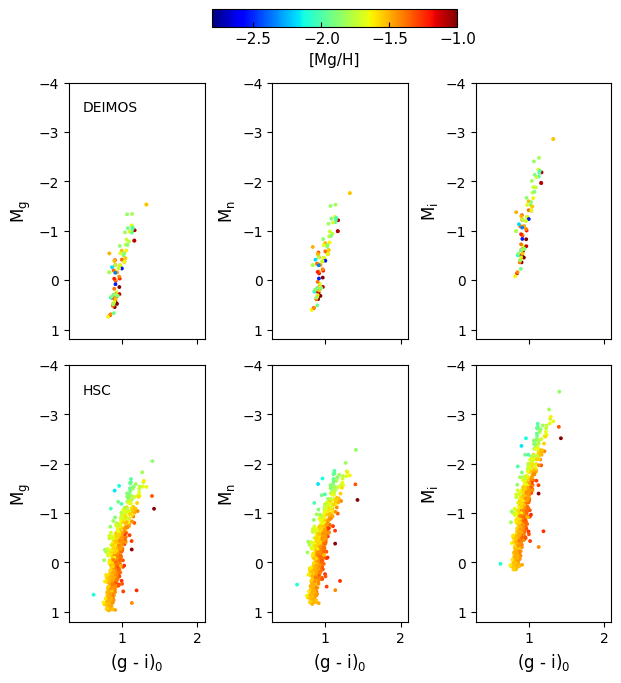

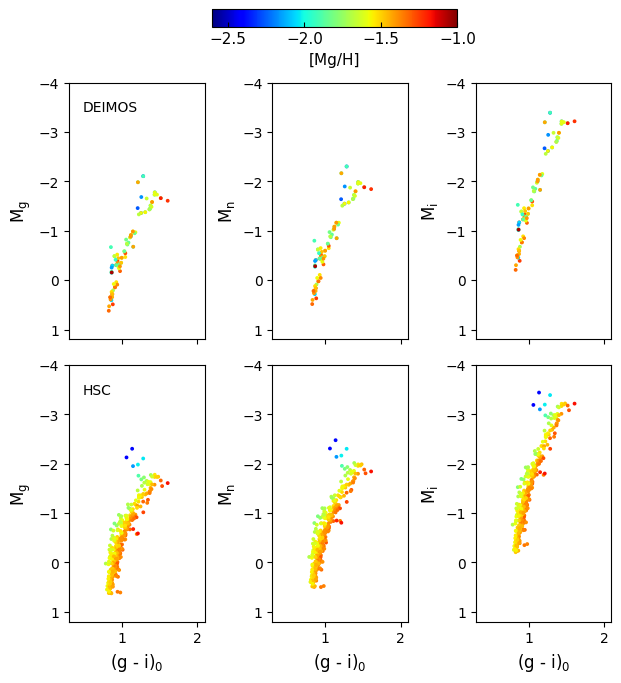

In [78]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.8 ; vmax = -1
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -2.6 ; vmax = -1
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/H]', size=11)
plt.savefig('cmd_deimos_hsc_mgh_Draco.png', bbox_inches='tight')

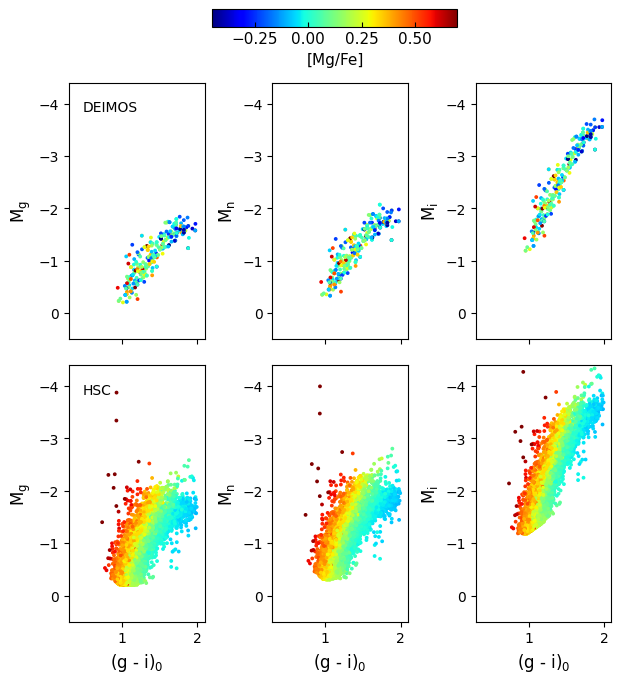

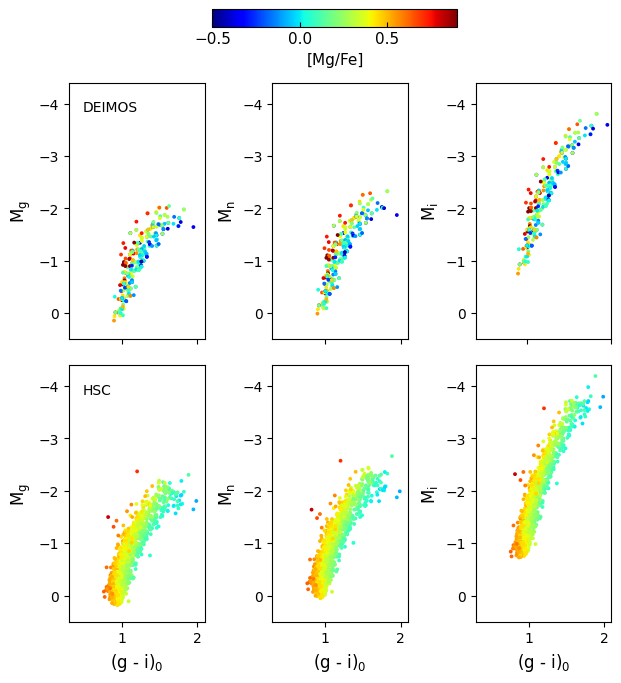

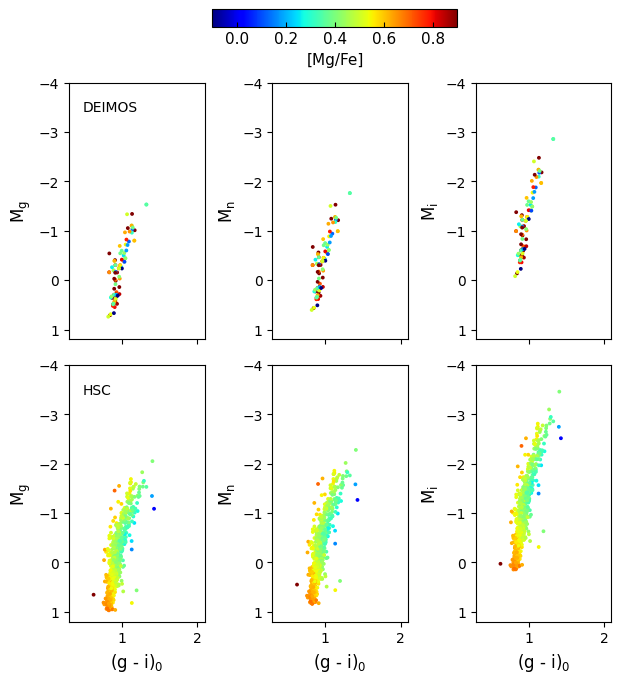

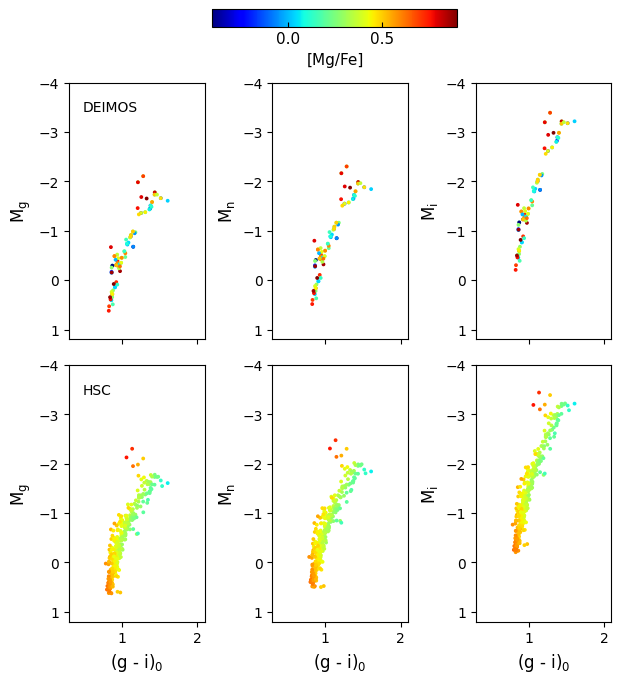

In [79]:
# Fornax
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
xmin = 0.3 ; xmax = 2.1
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -0.45 ; vmax = 0.7
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
#ax0.grid()
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mi0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mi0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Fornax.png', bbox_inches='tight')



# Sculptor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4.4 ; ymax = 0.5 ; s = 3
vmin = -0.5 ; vmax =0.9
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mi0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([0.4, 2])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mi0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -0.1 ; vmax = 0.9
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mi0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mi0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Ursaminor.png', bbox_inches='tight')


# Draco
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(7,7), gridspec_kw={'hspace':0.1, 'wspace':0.5})
ymin = -4 ; ymax = 1.2 ; s = 3
vmin = -0.4 ; vmax = 0.9
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymax, ymin])
ax0.set_xlabel('')
ax0.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.1, 0.93, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymax, ymin])
ax1.set_xlabel('')
ax1.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax1.set_xticklabels([])
ax2.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mi0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax2.set_xlim([xmin, xmax])
ax2.set_ylim([ymax, ymin])
ax2.set_xlabel('')
ax2.set_ylabel(r'M$_\mathrm{i}$', size=12)
ax2.set_xticklabels([])

ax3.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax3.set_xlim([xmin, xmax])
ax3.set_ylim([ymax, ymin])
ax3.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax3.set_ylabel(r'M$_\mathrm{g}$', size=12)
ax3.text(0.1, 0.93, 'HSC', ha='left', va='top', transform=ax3.transAxes)
ax4.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax4.set_xlim([xmin, xmax])
ax4.set_ylim([ymax, ymin])
ax4.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax4.set_ylabel(r'M$_\mathrm{n}$', size=12)
ax5.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mi0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax5.set_xlim([xmin, xmax])
ax5.set_ylim([ymax, ymin])
ax5.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax5.set_ylabel(r'M$_\mathrm{i}$', size=12)
cax = fig.add_axes([0.33, 0.96, 0.35, 0.025])  # [x, y, width, height] 지정
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=11, direction='in')
cbar.set_label('[Mg/Fe]', size=11)
plt.savefig('cmd_deimos_hsc_mgfe_Draco.png', bbox_inches='tight')

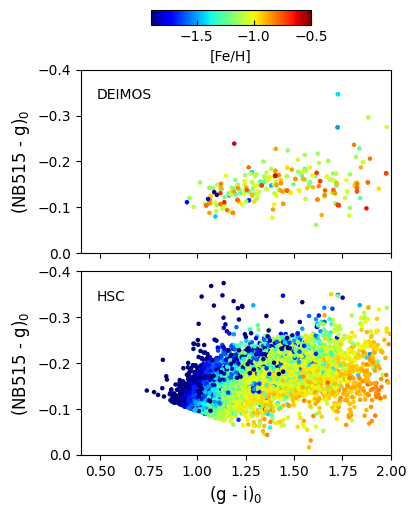

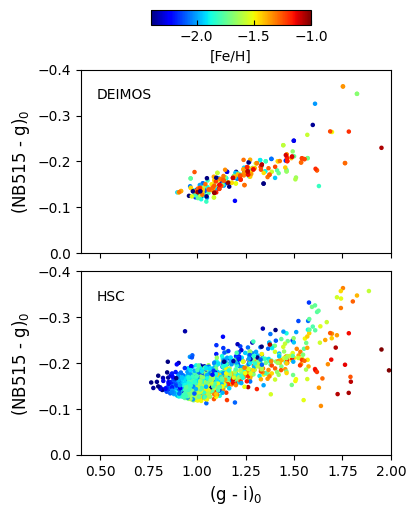

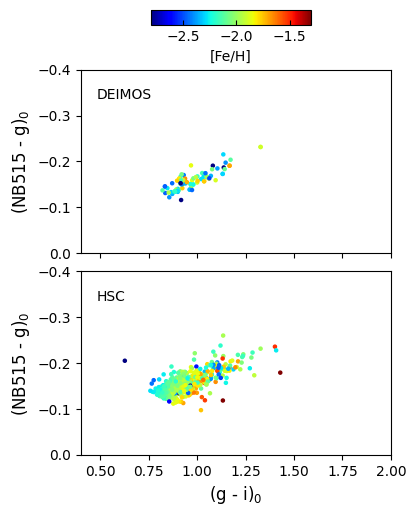

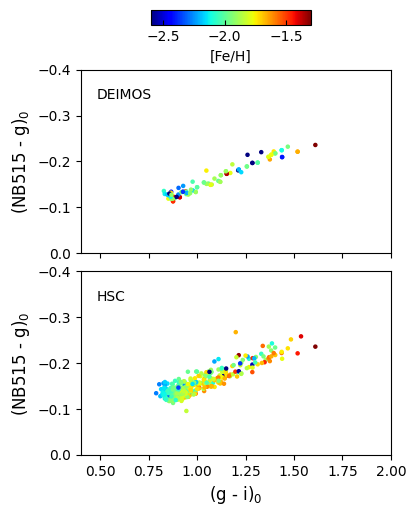

In [80]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Fornax.png', bbox_inches='tight')

# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.8 ; vmax = -1.3
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.6 ; vmax = -1.3
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['FEH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['FEH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Fe/H]', size=10)
plt.savefig('ccd_deimos_hsc_feh_Draco.png', bbox_inches='tight')

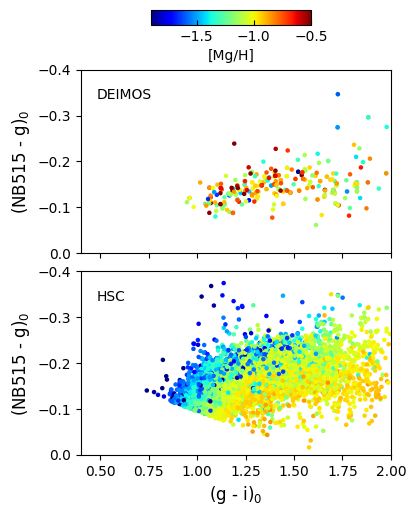

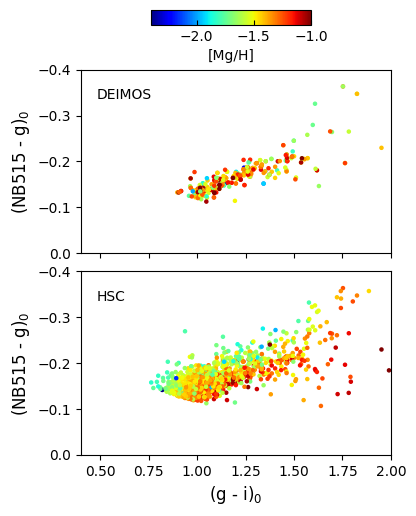

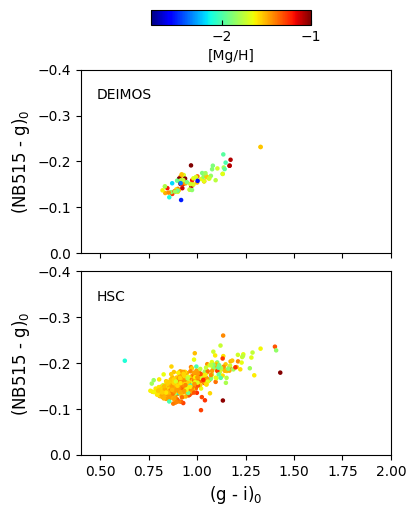

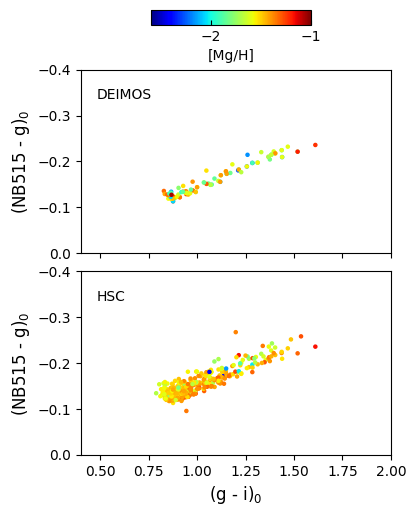

In [82]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -1.9 ; vmax = -0.5
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Fornax.png', bbox_inches='tight')


# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.4 ; vmax = -1
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.8 ; vmax = -1
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -2.6 ; vmax = -1
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGH'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGH_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/H]', size=10)
plt.savefig('ccd_deimos_hsc_mgh_Draco.png', bbox_inches='tight')

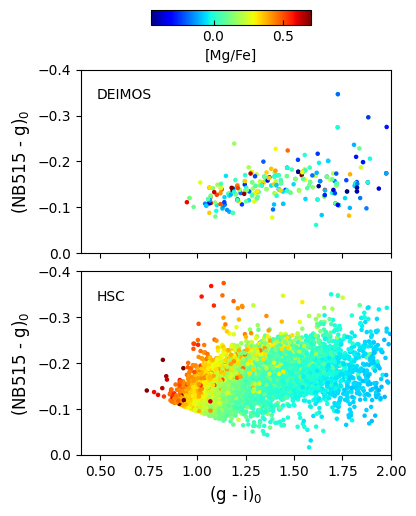

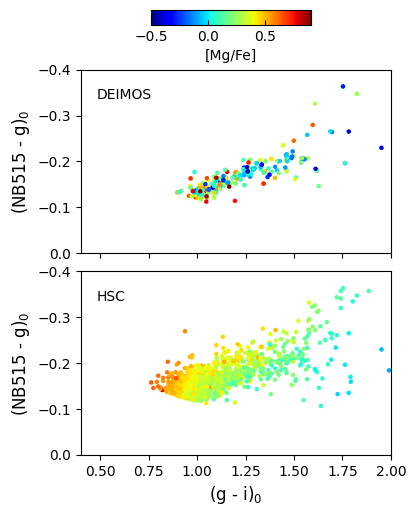

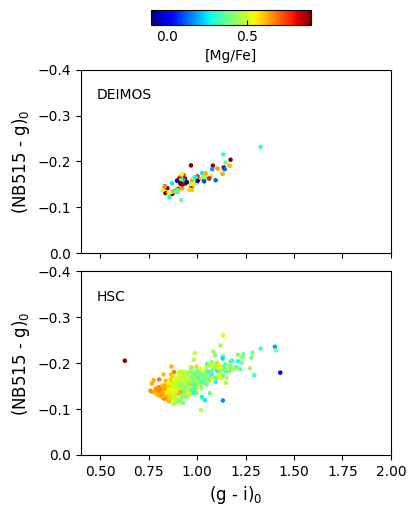

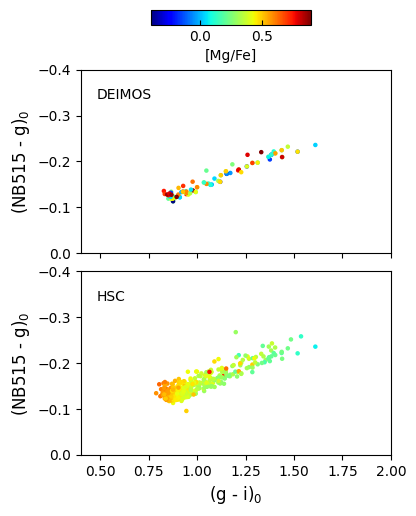

In [83]:
# Fornax
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.45 ; vmax = 0.7
im = ax0.scatter(fnx_mag['Mg0'] - fnx_mag['Mi0'], fnx_mag['Mn0'] - fnx_mag['Mg0'], marker='o', s=s, c=fnx_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_fnx_mag['Mg0'] - hsc_fnx_mag['Mi0'], hsc_fnx_mag['Mn0'] - hsc_fnx_mag['Mg0'], marker='o', s=s, c=hsc_fnx_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Fornax.png', bbox_inches='tight')


# Sculptor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.5 ; vmax = 0.9
im = ax0.scatter(scl_mag['Mg0'] - scl_mag['Mi0'], scl_mag['Mn0'] - scl_mag['Mg0'], marker='o', s=s, c=scl_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_scl_mag['Mg0'] - hsc_scl_mag['Mi0'], hsc_scl_mag['Mn0'] - hsc_scl_mag['Mg0'], marker='o', s=s, c=hsc_scl_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Sculptor.png', bbox_inches='tight')


# Ursa Minor
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.1 ; vmax = 0.9
im = ax0.scatter(umi_mag['Mg0'] - umi_mag['Mi0'], umi_mag['Mn0'] - umi_mag['Mg0'], marker='o', s=s, c=umi_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_umi_mag['Mg0'] - hsc_umi_mag['Mi0'], hsc_umi_mag['Mn0'] - hsc_umi_mag['Mg0'], marker='o', s=s, c=hsc_umi_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Ursaminor.png', bbox_inches='tight')


# Draco
fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(4,5), gridspec_kw={'hspace':0.1, 'wspace':0.4})
s = 5 ; vmin = -0.4 ; vmax = 0.9
im = ax0.scatter(dra_mag['Mg0'] - dra_mag['Mi0'], dra_mag['Mn0'] - dra_mag['Mg0'], marker='o', s=s, c=dra_mag['MGFE'], cmap='jet', vmin=vmin, vmax=vmax)
ax0.set_xlim([0.4, 2])
ax0.set_ylim([0, -0.4])
ax0.set_xlabel('')
ax0.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax0.set_xticklabels([])
ax0.text(0.05, 0.9, 'DEIMOS', ha='left', va='top', transform=ax0.transAxes)
ax1.scatter(hsc_dra_mag['Mg0'] - hsc_dra_mag['Mi0'], hsc_dra_mag['Mn0'] - hsc_dra_mag['Mg0'], marker='o', s=s, c=hsc_dra_mag['MGFE_phot_ann'], cmap='jet', vmin=vmin, vmax=vmax)
ax1.set_xlim([0.4, 2])
ax1.set_ylim([0, -0.4])
ax1.set_xlabel(r'(g - i)$_\mathrm{0}$', size=12)
ax1.set_ylabel(r'(NB515 - g)$_\mathrm{0}$', size=12)
ax1.text(0.05, 0.9, 'HSC', ha='left', va='top', transform=ax1.transAxes)
cax = fig.add_axes([0.3, 0.97, 0.4, 0.03])
fig.add_axes(cax)
cbar = fig.colorbar(im, cax=cax, orientation = 'horizontal')
cbar.ax.tick_params(labelsize=10, direction='in')
cbar.set_label('[Mg/Fe]', size=10)
plt.savefig('ccd_deimos_hsc_mgfe_Draco.png', bbox_inches='tight')